In [1]:
## Packages used
## Optimization done in Julia 1.1.1

# Pkg.add("Gurobi")
# Pkg.add("Combinatorics")
# Pkg.add("Distributions")
# Pkg.add("LinearAlgebra")
# Pkg.rm("Gurobi")
# Pkg.add("Gurobi")


In [1]:
# Load packages
using JuMP
using Gurobi
using Distributions
using Combinatorics
using Random
using LinearAlgebra
using Plots
# using PyPlot


In [3]:
# Main solver

function solvePricing(vals, probs)
    # Input: Matrix of valuations vectors and associated probability vector
    # Output: Optimal price vector found via MILP, and objective value.
    env = Gurobi.Env()
    m = Model(with_optimizer(Gurobi.Optimizer, env, OutputFlag=0, MIPGap = .001, Presolve = 1))

#     m = Model(solver=GurobiSolver()) #    
    customers = length(vals[:,1])
    items = length(vals[1,:])
    val_max = maximum(vals)
    # Binary Vars
    @variable(m, theta[i=1:customers, j=1:items], Bin)

    # LP Vars
    @variable(m, surp[i=1:customers] >= 0)
    @variable(m, cust_surp[i=1:customers, j=1:items] >= 0)
    @variable(m, price[i=1:items] >= 0)
    @variable(m, cust_price[i=1:customers, j=1:items] >= 0)

    #Objective
    @objective(m, Max, sum(cust_price[i,j]*probs[i] for i=1:customers,
j=1:items))

    # Constraints
    for i=1:customers
      for j=1:items
            @constraint(m, surp[i] >= vals[i,j] - price[j])
            @constraint(m, cust_surp[i,j] == vals[i,j]*theta[i,j]-cust_price[i,j])
            @constraint(m, cust_price[i,j] >= price[j] - (1-theta[i,j])*val_max)
            @constraint(m, cust_price[i,j] <= price[j])
        end
    end

    for i=1:customers
        @constraint(m, surp[i] == sum(cust_surp[i,j] for j=1:items))
        @constraint(m, sum(theta[i,j] for j=1:items) <= 1)
    end
    status = JuMP.optimize!(m)
    
    if termination_status(m) == MOI.OPTIMAL
        optimal_solution = value.(price)
        optimal_objective = objective_value(m)
    else
        error("The model was not solved correctly.")
    end
    
    return optimal_objective, optimal_solution
end

solvePricing (generic function with 1 method)

In [4]:
# Library of helper methods

function computeRevenue(prices, vals)
    # Input: Vector of prices and matrix of valuations
    # Output: Revenue
    tot = 0
    customers = length(vals[:,1])
    items = length(vals[1,:])

    for i =1:customers
        sup = vals[i,:] - prices
        curr_val = 0
        ind = 0
        if maximum(sup) >= 0
            for j=1:items
               if maximum(sup) == sup[j]
                    if vals[i,j] >= curr_val
                        curr_val = vals[i,j]
                        ind = j
                    end
                end
            end
        end
        if ind > 0
            tot = tot + prices[ind]
        end
    end
    return tot
end

function makeVals(customers, items, mean, std, para)
    # Input: Desired number of customer valuation vectors, number of items, and distr. info.
    # Output: A valuation matrix.
    Random.seed!(123)
    if para == 1
        # Normal
        d = Normal(mean, std)
    elseif para == 2
        # Gumbel: std is shape parameter
        d = Gumbel(mean, std*sqrt(6)/pi)
    else
        # Uniform: mean = a, std = b
        dist = sqrt(12)*std
        d = Uniform(mean-dist/2, mean+dist/2)
    end
    ret = rand(d, customers, items)
    ret[ret .< 0] .= 0
#     for i=1:length(ret[:,1])
#         for j=1:length(ret[1,:])
#             ret[i,j] = round(ret[i,j]*10)/10
#         end
#     end
    return ret  
end

function shuffle_vals(vals, order)
    # Input: Valuation matrix and order vector
    # Output: Shuffled valuation matrix
    for i = 1:length(vals[:,1])
        vals[i,:] = vals[i,:][order]
    end
    return vals
end

function makeRiskAverse(vals)
    # Input: Valuation matrix
    # Output: Risk-averse valuation matrix
    ovals = zeros(length(vals[:,1]), length(vals[1,:]))
    for i=1:length(vals[:,1])
        ovals[i,:] = sort(vals[i,:])
    end
    return ovals
end

function makeRiskNeutral(vals)
    # Input: Valuation matrix
    # Output: Risk-neutral valuation matrix
    ovals = zeros(length(vals[:,1]), length(vals[1,:]))
    for i=1:length(vals[:,1])
        for j = 1:length(vals[1,:])
            ovals[i,j] = sum(sort(vals[i,:])[j:length(vals[i,:])])/(length(vals[i,:])-j+1)
        end
    end
    return ovals
end

function makeRiskConvex(vals, gamma)
    # Input: Valuation matrix, mixing parameter.
    # Output: New valuation matrix that is convex combo. of RA and RN.
    vals_ra = makeRiskAverse(vals)
    vals_rn = makeRiskNeutral(vals)
    
    ovals = zeros(length(vals[:,1]), length(vals[1,:]))
    for i=1:length(vals[1,:])
        for j=1:length(vals[:,1])
            ovals[i,j] = gamma*vals_ra[i,j] + (1-gamma)*vals_ra[i,j]
        end
        
    end
end


function makeRiskNeutralBeta(vals, beta)
    # N = 2
    # beta is vector of weights, determining how a customer values items.
    ovals = zeros(length(vals[:,1]), 2)
    for i=1:length(vals[:,1])
        ovals[i,1] = maximum(vals[i,:])
        ovals[i,2] = beta[1]*vals[i,1] + beta[2]*vals[i,2]
    end
    return ovals
end


function makeOneOpaqueRA(vals)
    ovals = zeros(length(vals[:,1]), 2)
    for i=1:length(vals[:,1])
        ovals[i,1] = maximum(vals[i,:])
        ovals[i,2] = minimum(vals[i,:])
    end
    return ovals
end

function makeOneOpaqueRN(vals)
    ovals = zeros(length(vals[:,1]), 2)
    for i=1:length(vals[:,1])
        ovals[i,1] = maximum(vals[i,:])
        ovals[i,2] = mean(vals[i,:])
    end
    return ovals
end

function makeComplementaryVals(customers, reflect, mean, std, para)
    # N = 3
    Random.seed!(12345)
    if para == 1
        # Normal
        d = Normal(mean, std)
    elseif para == 2
        # Gumbel: std is shape parameter
        d = Gumbel(mean, std*sqrt(6)/pi)
    else
        # Uniform: mean = a, std = b
        dist = sqrt(12)*std
        d = Uniform(mean-dist/2, mean+dist/2)
    end
    
    ret = rand(d, customers, 1)
    ret[ret .< 0] .= 0
    dup_ret = zeros(2*length(ret),2)
    for i=1:length(ret[:,1])
        dup_ret[i,1] = ret[i]
        dup_ret[i,2] = reflect - ret[i]
    end
    
    for i=(length(ret[:,1])+1):2*length(ret[:,1])
        dup_ret[i,1] = reflect - ret[i-length(ret[:,1])]
        dup_ret[i,2] = ret[i-length(ret[:,1])]
    end

    return dup_ret  
end

function compute_sp(market, prob)
    new_market = zeros(length(market[:,1]))
    for i=1:length(market[:,1])
         new_market[i] = maximum(market[i,:])
    end
    rev = 0
    curr_rev = 0
    price = 0
    for i=1:length(new_market) # price index
        curr_rev = 0
        curr_price = new_market[i]
        for j=1:length(new_market) # loop through
            if new_market[j] >= curr_price
                curr_rev += curr_price*prob[j]
            end
        end
        if curr_rev >= rev
            rev = curr_rev
            price = curr_price
        end
    end
    return rev, price
end

function crossterms(support_1, support_probs_1, support_2, support_probs_2)
     # Have an N_1xM_1 matrix and a N_2 x M_2 matrix
    N_1, N_2 = length(support_1[:,1]), length(support_2[:,1])
    M_1, M_2 = length(support_1[1,:]), length(support_2[1,:])

    ret_support = zeros(N_1*N_2, M_1 + M_2)
    ret_probs = zeros(N_1*N_2)
    for i=1:N_1
        curr_1 = support_1[i,:]
        for j=1:N_2
            curr_2 = support_2[j,:]
            f = vcat(curr_1, curr_2)
            f = [float(f[i]) for i = 1:size(f,1)]
            ret_support[(i-1)*N_2+j, :] = f
            ret_probs[(i-1)*N_2+j] = support_probs_1[i]*support_probs_2[j]
        end
    end
    return ret_support, ret_probs
end

function makeiid(support, support_probs, k)
    N = length(support[:,1])

    ret_support = zeros(N^k, k)
    ret_probs = zeros(N^k)

    curr_supp = support
    curr_probs = support_probs
    for i = 1:k-1
        curr_supp, curr_probs = crossterms(curr_supp, curr_probs, support, support_probs)
    end
    return curr_supp, curr_probs
end

function makecopy(support, support_probs, k)
    N = length(support[:,1])

    ret_support = zeros(N, k)
    for i = 1:k
        ret_support[:,i] = support
    end
    return ret_support, support_probs
end

function makeonezero(support, support_probs, k)
    N = length(support[:,1])
    ret_support = zeros(k*N, k)
    ret_probs = zeros(k*N, 1)
    for i = 1:k
        ret_support[(N*(i-1)+1):N*i,i] = support
        ret_probs[(N*(i-1)+1):N*i] = support_probs./k
    end
    return ret_support, ret_probs
end



function makeComp(supp, prob, center)
    ret = zeros(2*length(supp[:,1]), 2)
    ret_prob = vcat(prob, prob)./2
    for i=1:length(supp[:,1])
        ret[i,1] = center - supp[i]
        ret[i,2] = supp[i]
    end

    for i = (length(supp[:,1])+1):2*length(supp[:,1])
        ret[i,1] = supp[i-length(supp[:,1])]
        ret[i,2] = center - supp[i-length(supp[:,1])]
    end
    return ret, ret_prob
end

makeComp (generic function with 1 method)

In [5]:
# More helper methods, mostly for the simulations

function makeExp(para, al, N)
    # para = 1,2,3
    # al is mixing proportion, N is number of items
    # returns raw valuation matricies, and opaque ones 
    Random.seed!(123)
    if para == 1
        d = TriangularDist(1, 7, 3)
        raw_samples = rand(d, 1000000)
        rounded_samples = round.(raw_samples)
        count = zeros(7,1)
        supp = range(1,stop=7,length=7)
        for i = 1:length(rounded_samples)
            for j = 1:7
                if rounded_samples[i] == j
                    count[j]+=1
                end
            end
        end
        prob = count./sum(count)
    elseif para == 2
        d = TruncatedNormal(3, 2, 1, 7)
        raw_samples = rand(d, 1000000)
        rounded_samples = round.(raw_samples)
        count = zeros(7,1)
        supp = range(1,stop=7,length=7)
        for i = 1:length(rounded_samples)
            for j = 1:7
                if rounded_samples[i] == j
                    count[j]+=1
                end
            end
        end
        prob = count./sum(count)
    else
        d = Bernoulli(1/9)
        raw_samples = 1 .+ 6*rand(d, 1000000)
        rounded_samples = round.(raw_samples)
        count = zeros(7,1)
        supp = range(1,stop=7,length=7)
        for i = 1:length(rounded_samples)
            for j = 1:7
                if rounded_samples[i] == j
                    count[j]+=1
                end
            end
        end
        prob = count./sum(count)
    end
    
    types_mat, types_prob = makeiid(supp,prob,N)
    opq_types_mat_RA = makeRiskAverse(types_mat)
    opq_types_mat_RN = makeRiskNeutral(types_mat)
    final_mat = vcat(opq_types_mat_RA, opq_types_mat_RN)
    final_prob = vcat(types_prob.*al, types_prob.*(1-al))
    return types_mat, types_prob, final_mat, final_prob
end


function makeExpVar(para, al, N, std)
    # para = 1,2,3
    # al is mixing proportion, N is number of items
    # returns raw valuation matricies, and opaque ones 
    sample_var = 0
    Random.seed!(123)
    if para == 1
        d = TriangularDist(3-std, 3+2*std, 3)
        raw_samples = rand(d, 1000000)
        rounded_samples = round.(raw_samples)
        sample_var = var(rounded_samples)
        count = zeros(7,1)
        supp = range(1,stop=7,length=7)
        for i = 1:length(rounded_samples)
            for j = 1:7
                if rounded_samples[i] == j
                    count[j]+=1
                end
            end
        end
        prob = count./sum(count)
    elseif para == 2
        d = TruncatedNormal(3, std, 1, 7)
        raw_samples = rand(d, 1000000)
        rounded_samples = round.(raw_samples)
        sample_var = var(rounded_samples)
        count = zeros(7,1)
        supp = range(1,stop=7,length=7)
        for i = 1:length(rounded_samples)
            for j = 1:7
                if rounded_samples[i] == j
                    count[j]+=1
                end
            end
        end
        prob = count./sum(count)
    else
        temp = std^2/7
        d = Bernoulli(.5 - .5*(1-4*temp)^(1/2))
        raw_samples = 1 .+ 6*rand(d, 1000000)
        rounded_samples = round.(raw_samples)
        sample_var = var(rounded_samples)
        count = zeros(7,1)
        supp = range(1,stop=7,length=7)
        for i = 1:length(rounded_samples)
            for j = 1:7
                if rounded_samples[i] == j
                    count[j]+=1
                end
            end
        end
        prob = count./sum(count)
    end
    
    types_mat, types_prob = makeiid(supp,prob,N)
    opq_types_mat_RA = makeRiskAverse(types_mat)
    opq_types_mat_RN = makeRiskNeutral(types_mat)
    final_mat = vcat(opq_types_mat_RA, opq_types_mat_RN)
    final_prob = vcat(types_prob.*al, types_prob.*(1-al))
    return types_mat, types_prob, final_mat, final_prob, sample_var
end



function compute_purchase_probs(supp, probs, prices)
    N = length(probs)
    items = length(supp[1,:])
    
    count_sales = zeros(items+1)
    tot = 0

    for i =1:N
        sup = supp[i,:] - prices
        curr_val = 0
        ind = 0
        if round(maximum(sup), digits = 4) >= 0
            for j=1:items
               if maximum(sup) == sup[j]
                    if supp[i,j] >= curr_val
                        curr_val = supp[i,j]
                        ind = j
                    end
                end
            end
        end
        if ind > 0
            count_sales[ind] = count_sales[ind] + probs[i]
        else
            count_sales[items+1] = count_sales[items+1] + probs[i]
        end
    end
    return count_sales    
end

function estimate_alpha(supp, types_prob, price, observed_sales_probs, N)
    # This needs to be done next, that will complete the necessary code for experiments
    
    al = range(0, stop=1, length=N)
    ret_al = 0
    dist = 1000000
    
    for i=1:N
        opq_types_mat_RA = makeRiskAverse(supp)
        opq_types_mat_RN = makeRiskNeutral(supp)
        final_mat = vcat(opq_types_mat_RA, opq_types_mat_RN)
        final_prob = vcat(types_prob.*al[i], types_prob.*(1-al[i]))
        curr_sales  = compute_purchase_probs(final_mat, final_prob, price)
        curr_dist = norm(curr_sales-observed_sales_probs)
        if curr_dist < dist
            dist = curr_dist
            ret_al = al[i]
        end
    end
    return ret_al
end

function make_samples(types_mat, types_prob, num)
    # Given a matrix of types and associated probabilities, return num random samples.
    ind = rand(num)
    ret = zeros(num,length(types_mat[1,:]))
    
    for j = 1:num
        ctr = 0
        for i = 1:length(types_mat[:,1])
            if ctr <= ind[j]
                ctr = ctr + types_prob[i]
                if ctr > ind[j]
                    ret[j,:] = types_mat[i,:]
                end
            end
        end
    end
    return ret
end


function computeWeightedRevenue(prices, vals, probs)
    tot = 0
    customers = length(vals[:,1])
    items = length(vals[1,:])

    for i =1:customers
        sup = vals[i,:] - prices
        curr_val = 0
        ind = 0
        if maximum(sup) >= 0
            for j=1:items
               if maximum(sup) == sup[j]
                    if vals[i,j] >= curr_val
                        curr_val = vals[i,j]
                        ind = j
                    end
                end
            end
        end
        if ind > 0
            tot = tot + prices[ind]*probs[i]
        end
    end
    return tot
end

function makeInterestingExp(para, al, N, b1, b2, b3)
    # para = 1,2,3
    # al is mixing proportion, N is number of items
    # returns raw valuation matricies, and opaque ones 
    # b1 is probs of iid (1,2,3)
    # b2 is probs of sames (1,1,1)
    # b3 is probs on pointed (0,1,0)
    
    Random.seed!(123)
    if para == 1
        d = TriangularDist(1, 7, 3)
        raw_samples = rand(d, 1000000)
        rounded_samples = round.(raw_samples)
        count = zeros(7,1)
        supp = range(1,stop=7,length=7)
        for i = 1:length(rounded_samples)
            for j = 1:7
                if rounded_samples[i] == j
                    count[j]+=1
                end
            end
        end
        prob = count./sum(count)
    elseif para == 2
        d = TruncatedNormal(3, 2, 1, 7)
        raw_samples = rand(d, 1000000)
        rounded_samples = round.(raw_samples)
        count = zeros(7,1)
        supp = range(1,stop=7,length=7)
        for i = 1:length(rounded_samples)
            for j = 1:7
                if rounded_samples[i] == j
                    count[j]+=1
                end
            end
        end
        prob = count./sum(count)
    else
        d = Bernoulli(1/9)
        raw_samples = 1 .+ 6*rand(d, 1000000)
        rounded_samples = round.(raw_samples)
        count = zeros(7,1)
        supp = range(1,stop=7,length=7)
        for i = 1:length(rounded_samples)
            for j = 1:7
                if rounded_samples[i] == j
                    count[j]+=1
                end
            end
        end
        prob = count./sum(count)
    end
    
    types_mat_iid, types_prob_iid = makeiid(supp,prob,N)
    types_mat_same, types_prob_same = makecopy(supp,prob,N)
    types_mat_pointed, types_prob_pointed = makeonezero(supp,prob,N)
    
    mix = vcat(types_mat_same, types_mat_pointed)
    final_mix = vcat(types_mat_iid, mix)
    mix_prob = vcat(types_prob_same.*b2, types_prob_pointed.*b3)
    final_mix_prob = vcat(types_prob_iid*b1, mix_prob)
    
    opq_types_mat_RA = makeRiskAverse(final_mix)
    opq_types_mat_RN = makeRiskNeutral(final_mix)
    final_mat = vcat(opq_types_mat_RA, opq_types_mat_RN)
    final_prob = vcat(final_mix_prob.*al, final_mix_prob.*(1-al))
    return final_mix, final_mix_prob, final_mat, final_prob
end

function makeExpBeta(para, beta, N)
    # para = 1,2,3
    # al is mixing proportion, N is number of items
    # returns raw valuation matricies, and opaque ones 
    Random.seed!(123)
    if para == 1
        d = TriangularDist(1, 7, 3)
        raw_samples = rand(d, 1000000)
        rounded_samples = round.(raw_samples)
        count = zeros(7,1)
        supp = range(1,stop=7,length=7)
        for i = 1:length(rounded_samples)
            for j = 1:7
                if rounded_samples[i] == j
                    count[j]+=1
                end
            end
        end
        prob = count./sum(count)
    elseif para == 2
        d = TruncatedNormal(3, 2, 1, 7)
        raw_samples = rand(d, 1000000)
        rounded_samples = round.(raw_samples)
        count = zeros(7,1)
        supp = range(1,stop=7,length=7)
        for i = 1:length(rounded_samples)
            for j = 1:7
                if rounded_samples[i] == j
                    count[j]+=1
                end
            end
        end
        prob = count./sum(count)
    else
        d = Bernoulli(1/9)
        raw_samples = 1 .+ 6*rand(d, 1000000)
        rounded_samples = round.(raw_samples)
        count = zeros(7,1)
        supp = range(1,stop=7,length=7)
        for i = 1:length(rounded_samples)
            for j = 1:7
                if rounded_samples[i] == j
                    count[j]+=1
                end
            end
        end
        prob = count./sum(count)
    end
    types_mat, types_prob = makeiid(supp,prob,N)
    opq_types_mat_RN = makeRiskNeutralBeta(types_mat, beta)
    return types_mat, types_prob, opq_types_mat_RN, types_prob
end

makeExpBeta (generic function with 1 method)

In [6]:
# Test Crap
# a,b,c,d = makeExp(1, .3, 3)
# rev, price = solvePricing(a,b)
# rev_opq, price_opq = solvePricing(c,d)
# price_opq[1] = 3
# price_opq
# samples = make_samples(c, d, 50)
# sample_probs = ones(50)./50
# observed = compute_purchase_probs(c, d, price_opq)
# al = estimate_alpha(a, b, price_opq, observed, 1000)

# a,b,c,d,e = makeExpVar(1, 0, 4, .6)
# a,b,c,d = makeInterestingExp(1, 1, 4, .5, .25, .25)
# rev, price = solvePricing(a,b)
# rev_opq, price_opq = solvePricing(c,d)
# rev, rev_opq

tt1, t2, t3, t4 = makeExpBeta(1, [0, 1], 2)

([1.0 1.0; 1.0 2.0; … ; 7.0 6.0; 7.0 7.0], [0.000442892, 0.00350538, 0.00634982, 0.00526146, 0.00351369, 0.0017508, 0.000220951, 0.00350538, 0.0277442, 0.0502573  …  0.01389, 0.00692108, 0.000873443, 0.000220951, 0.00174878, 0.00316782, 0.00262485, 0.00175292, 0.000873443, 0.000110229], [1.0 1.0; 2.0 2.0; … ; 7.0 6.0; 7.0 7.0], [0.000442892, 0.00350538, 0.00634982, 0.00526146, 0.00351369, 0.0017508, 0.000220951, 0.00350538, 0.0277442, 0.0502573  …  0.01389, 0.00692108, 0.000873443, 0.000220951, 0.00174878, 0.00316782, 0.00262485, 0.00175292, 0.000873443, 0.000110229])

In [ ]:
# Okay lets do some experiments

In [7]:
# New Experiment 1 - Type 1, misspecified betas
a,b,opq_mix, prob_opq_mix = makeExp(1, .5, 3)
~,~,opq_zero, prob_opq_zero = makeExp(1, 0, 3)
~,~,opq_one, prob_opq_one = makeExp(1, 1, 3)

rev_dp_1, ~ = solvePricing(a, b)
rev_sp_1, ~ = compute_sp(a, b)

rev_opq_mix, price_opq_mix = solvePricing(opq_mix, prob_opq_mix)
rev_opq_zero, price_opq_zero = solvePricing(opq_zero, prob_opq_zero)
rev_opq_one, price_opq_one = solvePricing(opq_one, prob_opq_one)

for i = 1:length(price_opq_mix)
    price_opq_mix[i] = round(price_opq_mix[i], digits = 4)
    price_opq_zero[i] = round(price_opq_zero[i], digits = 4)
    price_opq_one[i] = round(price_opq_one[i], digits = 4)
end

gran = 20

rev_opq_mix = zeros(gran)
rev_opq_zero = zeros(gran)
rev_opq_one = zeros(gran)
rev_opt = zeros(gran)

rev_dp = ones(gran).*round(rev_dp_1, digits = 4)
rev_sp = ones(gran).*round(rev_sp_1, digits = 4) 

alphas = range(0, stop=1, length=gran)

for i=1:gran
    ~, ~, opq_test, prob_opq_test = makeExp(1, alphas[i], 3)
    
    rev_opq_mix[i] = round(computeWeightedRevenue(price_opq_mix, opq_test, prob_opq_test), digits = 4)
    rev_opq_zero[i] = round(computeWeightedRevenue(price_opq_zero, opq_test, prob_opq_test), digits = 4)
    rev_opq_one[i] = round(computeWeightedRevenue(price_opq_one, opq_test, prob_opq_test), digits = 4)
    curr, ~ = solvePricing(opq_test, prob_opq_test)
    rev_opt[i] = round(curr, digits = 4)
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [7]:
using Plots

# plot(alphas, rev_opq_mix)

x_vars = ones(gran)
type1_y_vars = ones(gran, 6)

# for i=1:gran
#      x_vars[i] = alphas[i]
#     type1_y_vars[i,1] = rev_opq_mix[i]/rev_sp[i]
#     type1_y_vars[i,2] = rev_opq_zero[i]/rev_sp[i]
#     type1_y_vars[i,3] = rev_opq_one[i]/rev_sp[i]
#     type1_y_vars[i,4] = rev_opt[i]/rev_sp[i]
#     type1_y_vars[i,5] = rev_dp[i]/rev_sp[i]
# #     y_vars[i,6] = rev_sp[i]
# end

# for i=1:gran
#      x_vars[i] = alphas[i]
#     type1_y_vars[i,1] = rev_opq_mix[i]/rev_sp[i]
#     type1_y_vars[i,2] = rev_opq_zero[i]/rev_sp[i]
#     type1_y_vars[i,3] = rev_opq_one[i]/rev_sp[i]
#     type1_y_vars[i,4] = rev_opt[i]/rev_sp[i]
# end


for i=1:gran
     x_vars[i] = alphas[i]
    type1_y_vars[i,1] = rev_opq_mix[i]
    type1_y_vars[i,2] = rev_opq_zero[i]
    type1_y_vars[i,3] = rev_opq_one[i]
    type1_y_vars[i,4] = rev_opt[i]
end

In [8]:
# Symbol[:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
plot(x_vars, type1_y_vars[:,2], linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,3], linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,4], linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)

savefig("type_1_1_0_opt.png")

In [9]:
# New Experiment 2 - Type 2, misspecified betas
a,b,opq_mix, prob_opq_mix = makeExp(2, .5, 3)
~,~,opq_zero, prob_opq_zero = makeExp(2, 0, 3)
~,~,opq_one, prob_opq_one = makeExp(2, 1, 3)

rev_dp_1, ~ = solvePricing(a, b)
rev_sp_1, ~ = compute_sp(a, b)

rev_opq_mix, price_opq_mix = solvePricing(opq_mix, prob_opq_mix)
rev_opq_zero, price_opq_zero = solvePricing(opq_zero, prob_opq_zero)
rev_opq_one, price_opq_one = solvePricing(opq_one, prob_opq_one)

for i = 1:length(price_opq_mix)
    price_opq_mix[i] = round(price_opq_mix[i], digits = 4)
    price_opq_zero[i] = round(price_opq_zero[i], digits = 4)
    price_opq_one[i] = round(price_opq_one[i], digits = 4)
end


gran = 20

rev_opq_mix = zeros(gran)
rev_opq_zero = zeros(gran)
rev_opq_one = zeros(gran)
rev_opt = zeros(gran)

rev_dp = ones(gran).*round(rev_dp_1, digits = 4)
rev_sp = ones(gran).*round(rev_sp_1, digits = 4)

alphas = range(0, stop=1, length=gran)

for i=1:gran
    ~, ~, opq_test, prob_opq_test = makeExp(2, alphas[i], 3)
    
    rev_opq_mix[i] = round(computeWeightedRevenue(price_opq_mix, opq_test, prob_opq_test), digits = 4)
    rev_opq_zero[i] = round(computeWeightedRevenue(price_opq_zero, opq_test, prob_opq_test), digits = 4)
    rev_opq_one[i] = round(computeWeightedRevenue(price_opq_one, opq_test, prob_opq_test), digits = 4)
    curr, ~ = solvePricing(opq_test, prob_opq_test)
    rev_opt[i] = round(curr, digits = 4)
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [10]:
using Plots

# plot(alphas, rev_opq_mix)

x_vars = ones(gran)
type2_y_vars = ones(gran, 5)

for i=1:gran
     x_vars[i] = alphas[i]
    type2_y_vars[i,1] = rev_opq_mix[i]
    type2_y_vars[i,2] = rev_opq_zero[i]
    type2_y_vars[i,3] = rev_opq_one[i]
    type2_y_vars[i,4] = rev_opt[i]
    type2_y_vars[i,5] = rev_dp[i]
#     y_vars[i,6] = rev_sp[i]
end

In [11]:
# plot(x_vars, type2_y_vars[:,2:4], legend = false)
# # savefig("type_2_mix_0_1_opt_dp.png")
plot(x_vars, type2_y_vars[:,2], linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type2_y_vars[:,3], linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type2_y_vars[:,4], linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)

savefig("type_2_1_0_opt.png")

In [12]:
# New Experiment 3 - Type 3, misspecified betas
a,b,opq_mix, prob_opq_mix = makeExp(3, .5, 3)
~,~,opq_zero, prob_opq_zero = makeExp(3, 0, 3)
~,~,opq_one, prob_opq_one = makeExp(3, 1, 3)

rev_dp_1, ~ = solvePricing(a, b)
rev_sp_1, ~ = compute_sp(a, b)

rev_opq_mix, price_opq_mix = solvePricing(opq_mix, prob_opq_mix)
rev_opq_zero, price_opq_zero = solvePricing(opq_zero, prob_opq_zero)
rev_opq_one, price_opq_one = solvePricing(opq_one, prob_opq_one)

for i = 1:length(price_opq_mix)
    price_opq_mix[i] = round(price_opq_mix[i], digits = 4)
    price_opq_zero[i] = round(price_opq_zero[i], digits = 4)
    price_opq_one[i] = round(price_opq_one[i], digits = 4)
end

gran = 20

rev_opq_mix = zeros(gran)
rev_opq_zero = zeros(gran)
rev_opq_one = zeros(gran)
rev_opt = zeros(gran)

rev_dp = ones(gran).*round(rev_dp_1, digits = 4)
rev_sp = ones(gran).*round(rev_sp_1, digits = 4)

alphas = range(0, stop=1, length=gran)

for i=1:gran
    ~, ~, opq_test, prob_opq_test = makeExp(3, alphas[i], 3)
    rev_opq_mix[i] = round(computeWeightedRevenue(price_opq_mix, opq_test, prob_opq_test), digits = 4)
    rev_opq_zero[i] = round(computeWeightedRevenue(price_opq_zero, opq_test, prob_opq_test), digits = 4)
    rev_opq_one[i] = round(computeWeightedRevenue(price_opq_one, opq_test, prob_opq_test), digits = 4)
    curr, ~ = solvePricing(opq_test, prob_opq_test)
    rev_opt[i] = round(curr, digits = 4)
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [13]:
using Plots

# plot(alphas, rev_opq_mix)

x_vars = ones(gran)
type3_y_vars = ones(gran, 5)

for i=1:gran
     x_vars[i] = alphas[i]
    type3_y_vars[i,1] = rev_opq_mix[i]
    type3_y_vars[i,2] = rev_opq_zero[i]
    type3_y_vars[i,3] = rev_opq_one[i]
    type3_y_vars[i,4] = rev_opt[i]
    type3_y_vars[i,5] = rev_dp[i]
#     y_vars[i,6] = rev_sp[i]
end

In [14]:
# plot(x_vars, type3_y_vars[:,2:4], legend = false)
# savefig("type_3_mix_0_1_opt_dp.png")
plot(x_vars, type3_y_vars[:,2], linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type3_y_vars[:,3], linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type3_y_vars[:,4], linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)

savefig("type_3_1_0_opt.png")

In [114]:
# New Experiment 4 - Type 1, Fiting alpha from data

a,b,opq_one, prob_opq_one = makeExp(1, 1, 3)

rev_dp_1, ~ = solvePricing(a, b)
rev_sp_1, ~ = compute_sp(a, b)

rev_opq_one, price_opq_one = solvePricing(opq_one, prob_opq_one)

# Rounds the elements of the price vector.
for i = 1:length(price_opq_one)
    price_opq_one[i] = round(price_opq_one[i], digits = 4)
end
print(price_opq_one)

gran = 50 # just 10

prices_opt = zeros(gran, 3) # necessary for future
rev_opt = zeros(gran)
rev_10 = zeros(gran)
rev_100 = zeros(gran)
al10 = zeros(gran)
al100 = zeros(gran)

# rev_500 = zeros(gran)

rev_dp = ones(gran).*round(rev_dp_1, digits = 4)
rev_sp = ones(gran).*round(rev_sp_1, digits = 4)

alphas = range(0, stop=1, length=gran)

for i=1:gran
    ~, ~, opq_test, prob_opq_test = makeExp(1, alphas[i], 3)
    curr, curr2 = solvePricing(opq_test, prob_opq_test)
    rev_opt[i] = round(curr, digits = 4)
    for j = 1:3
        prices_opt[i,j] = round(curr2[j], digits = 4)
    end
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
[3.0, 4.0, 4.0]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use onl

In [115]:
# Imagine being given a vector of optimal prices for different al's (maybe every .025, so I solve with gran 40)
# This is called prices opt

num_estimates = 50 # one estimation for each of 100 samples
rev_10 = zeros(gran, num_estimates) 
rev_100 = zeros(gran, num_estimates)
rev_1000 = zeros(gran, num_estimates)
al10 = zeros(gran, num_estimates) 
al100 = zeros(gran, num_estimates)
al1000 = zeros(gran, num_estimates)

for i = 1:gran
     a, b, opq_test, prob_opq_test = makeExp(1, alphas[i], 3)
    for j = 1:num_estimates
        
#         for k=1:length(price_opq_one)
#             price_opq_one[k] = 3 + round(3-6*rand(1)[1], digits = 4) # add some randomness to the estimation
#         end
        price_opq_one = [3.8357, 4.399, 5.6094]
        
        # 10
        samples10 = make_samples(opq_test, prob_opq_test, 10)
        observed10 = compute_purchase_probs(samples10, ones(10)./10, price_opq_one) # price_opq_one
        al10[i,j] = estimate_alpha(a, b, price_opq_one, observed10, 1000)
#         ~,~,opq_10, prob_opq_10 = makeExp(1, al10[i], 3)

        # Find closest alpha on support
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al10[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al10[i,j] - alphas[k])
                curr_ind = k
            end
        end
        rev_10[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_test, prob_opq_test), digits = 4)
        
        # 100
        samples100 = make_samples(opq_test, prob_opq_test, 100)
        observed100 = compute_purchase_probs(samples100, ones(100)./100, price_opq_one) # price_opq_one
        al100[i,j] = estimate_alpha(a, b, price_opq_one, observed100, 1000)
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al100[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al100[i,j] - alphas[k])
                curr_ind = k
            end
        end
        rev_100[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_test, prob_opq_test), digits = 4)
        
        # 1000
        samples1000 = make_samples(opq_test, prob_opq_test, 1000)
        observed1000 = compute_purchase_probs(samples1000, ones(1000)./1000, price_opq_one) # price_opq_one
        al1000[i,j] = estimate_alpha(a, b, price_opq_one, observed1000, 1000)
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al1000[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al1000[i,j] - alphas[k])
                curr_ind = k
            end
        end
        rev_1000[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_test, prob_opq_test), digits = 4)
    end
end

In [121]:
# Compute the percent error's here on revenue and alpha

curr10 = 0
curr100 = 0
curr1000 = 0
revcurr10 = 0
revcurr100 = 0
revcurr1000 = 0

for i = 2:gran
    a, b, opq_test, prob_opq_test = makeExp(1, alphas[i], 3)
    for j=1:num_estimates
        curr10 += abs(alphas[i] - al10[i,j])
        curr100 += abs(alphas[i] - al100[i,j])
        curr1000 += abs(alphas[i] - al1000[i,j])
        curr_opt = round(computeWeightedRevenue(prices_opt[i,:], opq_test, prob_opq_test), digits = 4)
        revcurr10 += abs(curr_opt - rev_10[i,j])/curr_opt
        revcurr100 += abs(curr_opt - rev_100[i,j])/curr_opt
        revcurr1000 += abs(curr_opt - rev_1000[i,j])/curr_opt
    end
end

println(curr10/(gran*num_estimates))
println(curr100/(gran*num_estimates))
println(curr1000/(gran*num_estimates))
println(revcurr10/(gran*num_estimates))
println(revcurr100/(gran*num_estimates))
println(revcurr1000/(gran*num_estimates))

0.3189094809094794
0.15048877448877376
0.05102925782925782
0.005874711008661933
0.0013943346615366997
0.00012323002866375062


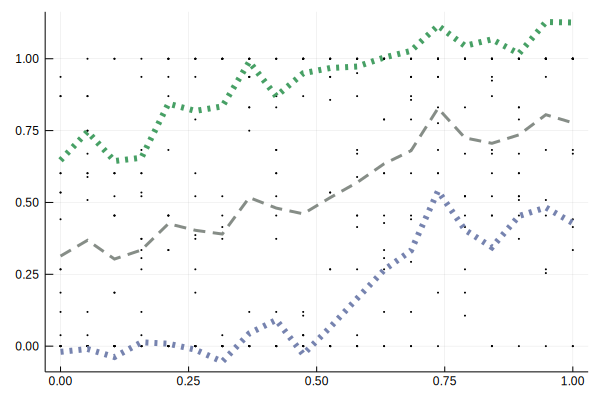

In [27]:
mean_est_10 = zeros(gran)
mean_est_100 = zeros(gran)
mean_est_1000 = zeros(gran)
std_10 = zeros(gran)
std_100 = zeros(gran)
std_1000 = zeros(gran)

for i=1:gran
    mean_est_10[i] = mean(al10[i,:])
    mean_est_100[i] = mean(al100[i,:])
    mean_est_1000[i] = mean(al1000[i,:])
    std_10[i] = std(al10[i,:])
    std_100[i] = std(al100[i,:])
    std_1000[i] = std(al1000[i,:])
end

plot(alphas, al10, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, mean_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, mean_est_10 + std_10, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
plot!(alphas, mean_est_10 - std_10, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
# savefig("type_1_robust_al10.png")

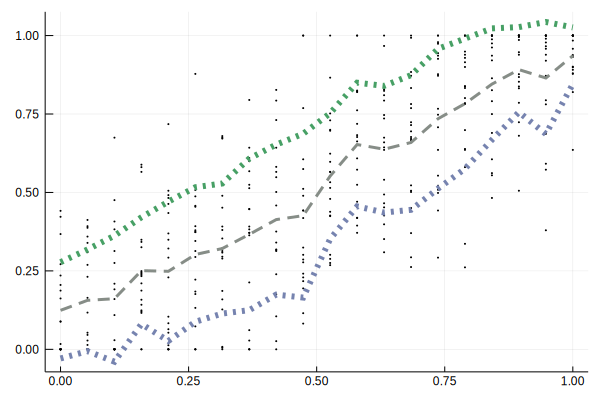

In [28]:
plot(alphas, al100, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, mean_est_100, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, mean_est_100 + std_100, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
plot!(alphas, mean_est_100 - std_100, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
# savefig("type_1_robust_al100.png")

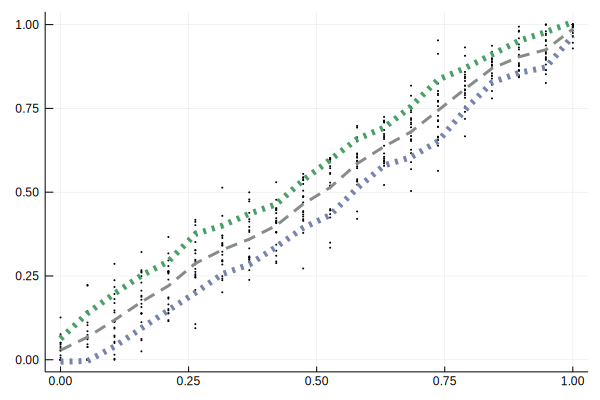

In [29]:
plot(alphas, al1000, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, mean_est_1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, mean_est_1000 + std_1000, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
plot!(alphas, mean_est_1000 - std_1000, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
# savefig("type_1_robust_al1000.png")

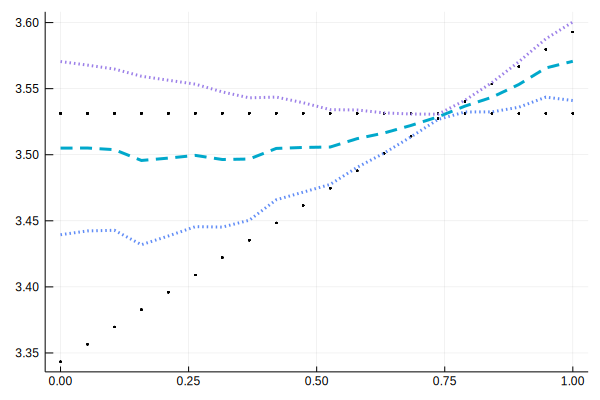

In [35]:
# Al's revenue now
rev_est_10 = zeros(gran)
rev_est_100 = zeros(gran)
rev_est_1000 = zeros(gran)
rstd_10 = zeros(gran)
rstd_100 = zeros(gran)
rstd_1000 = zeros(gran)

for i=1:gran
    rev_est_10[i] = mean(rev_10[i,:])
    rev_est_100[i] = mean(rev_100[i,:])
    rev_est_1000[i] = mean(rev_1000[i,:])
    rstd_10[i] = std(rev_10[i,:])
    rstd_100[i] = std(rev_100[i,:])
    rstd_1000[i] = std(rev_1000[i,:])
end

plot(alphas, rev_10, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, rev_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev_est_10 + rstd_10, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev_est_10 - rstd_10, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
# savefig("type_1_robust_rev10.png")

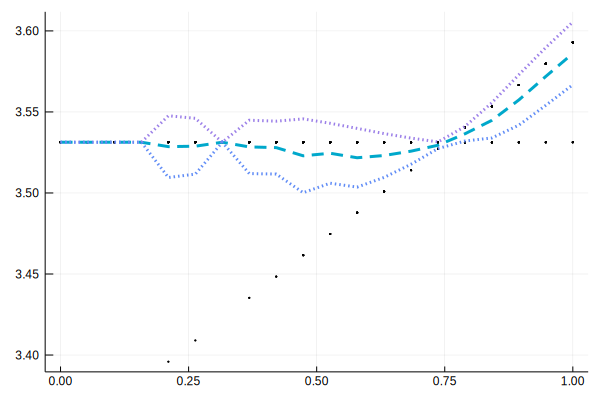

In [36]:
plot(alphas, rev_100, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, rev_est_100, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev_est_100 + rstd_100, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev_est_100 - rstd_100, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
# savefig("type_1_robust_rev100.png")

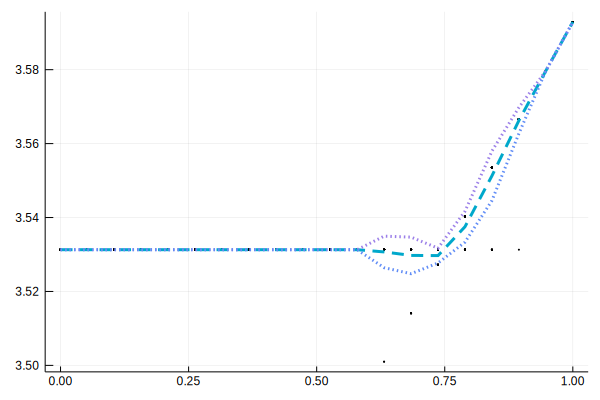

In [37]:
plot(alphas, rev_1000, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, rev_est_1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev_est_1000 + rstd_1000, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev_est_1000 - rstd_1000, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
# savefig("type_1_robust_rev1000.png")

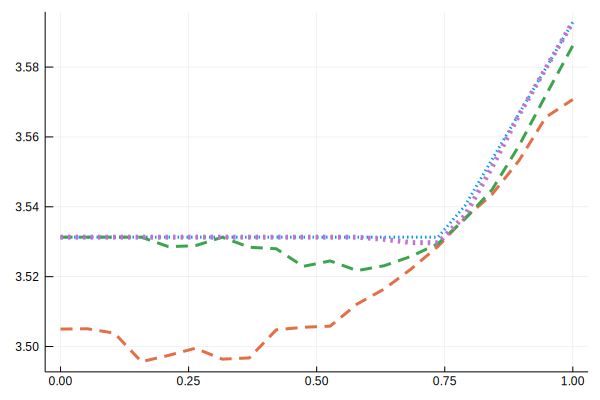

In [38]:
plot(alphas, rev_opt, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev_est_100, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev_est_1000, linestyle = :dot, linewidth = 5, legend = false, reuse = true)
# savefig("type_1_robust_all.png")

In [39]:
plot(alphas, rev_opt, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev_est_100, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev_est_1000, linestyle = :dot, linewidth = 5, legend = false, reuse = true)
savefig("type_1_robust_all.png")

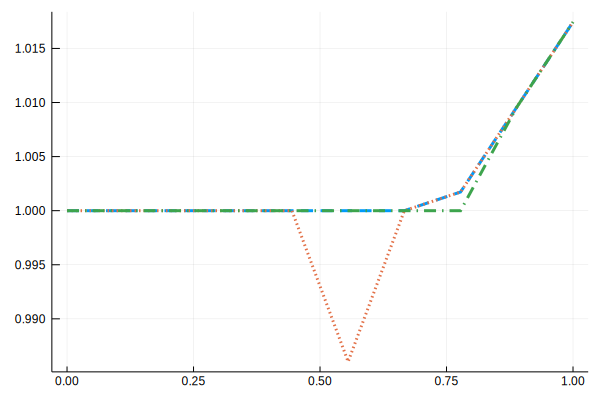

In [39]:
# One sample path plots
using Plots

# plot(alphas, rev_opq_mix)

x_vars = ones(gran)
type4_y_vars = ones(gran, 3)

for i=1:gran
     x_vars[i] = alphas[i]
    type4_y_vars[i,1] = rev_opt[i]/rev_sp[i]
    type4_y_vars[i,2] = rev_10[i]/rev_sp[i]
    type4_y_vars[i,3] = rev_100[i]/rev_sp[i]
end

plot(x_vars, type4_y_vars[:,1], linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type4_y_vars[:,2], linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type4_y_vars[:,3], linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)


# plot(x_vars, type4_y_vars[:,1:3], legend = false)
# savefig("type_4_10_100.png")

In [122]:
# New Experiment 5 - Type 2, Fiting alpha from data

a,b,opq_one, prob_opq_one = makeExp(2, 1, 3)

rev_dp_1, ~ = solvePricing(a, b)
rev_sp_1, ~ = compute_sp(a, b)

rev_opq_one, price_opq_one = solvePricing(opq_one, prob_opq_one)

# Rounds the elements of the price vector.
for i = 1:length(price_opq_one)
    price_opq_one[i] = round(price_opq_one[i], digits = 4)
end
print(price_opq_one)

gran = 50 # just 10

prices_opt = zeros(gran, 3) # necessary for future
rev_opt = zeros(gran)
rev_10 = zeros(gran)
rev_100 = zeros(gran)
al10 = zeros(gran)
al100 = zeros(gran)

# rev_500 = zeros(gran)

rev_dp = ones(gran).*round(rev_dp_1, digits = 4)
rev_sp = ones(gran).*round(rev_sp_1, digits = 4)

alphas = range(0, stop=1, length=gran)

for i=1:gran
    ~, ~, opq_test, prob_opq_test = makeExp(2, alphas[i], 3)
    curr, curr2 = solvePricing(opq_test, prob_opq_test)
    rev_opt[i] = round(curr, digits = 4)
    for j = 1:3
        prices_opt[i,j] = round(curr2[j], digits = 4)
    end
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
[3.0, 3.0, 4.0]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use onl

In [123]:
num_estimates = 50 # one estimation for each of 100 samples
rev_10 = zeros(gran, num_estimates) 
rev_100 = zeros(gran, num_estimates)
rev_1000 = zeros(gran, num_estimates)
al10 = zeros(gran, num_estimates) 
al100 = zeros(gran, num_estimates)
al1000 = zeros(gran, num_estimates)

for i = 1:gran
     a, b, opq_test, prob_opq_test = makeExp(2, alphas[i], 3)
    for j = 1:num_estimates
        
#         for k=1:length(price_opq_one)
#             price_opq_one[k] = 3 + round(3-6*rand(1)[1], digits = 4) # add some randomness to the estimation
#         end
        price_opq_one = [2.6008, 3.732, 5.6962]
        
        # 10
        samples10 = make_samples(opq_test, prob_opq_test, 10)
        observed10 = compute_purchase_probs(samples10, ones(10)./10, price_opq_one) # price_opq_one
        al10[i,j] = estimate_alpha(a, b, price_opq_one, observed10, 1000)
#         ~,~,opq_10, prob_opq_10 = makeExp(1, al10[i], 3)

        # Find closest alpha on support
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al10[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al10[i,j] - alphas[k])
                curr_ind = k
            end
        end
        rev_10[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_test, prob_opq_test), digits = 4)
        
        # 100
        samples100 = make_samples(opq_test, prob_opq_test, 100)
        observed100 = compute_purchase_probs(samples100, ones(100)./100, price_opq_one) # price_opq_one
#         print(price_opq_one)
#         print(observed100)
        al100[i,j] = estimate_alpha(a, b, price_opq_one, observed100, 1000)
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al100[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al100[i,j] - alphas[k])
                curr_ind = k
            end
        end
        rev_100[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_test, prob_opq_test), digits = 4)
        
        # 1000
        samples1000 = make_samples(opq_test, prob_opq_test, 1000)
        observed1000 = compute_purchase_probs(samples1000, ones(1000)./1000, price_opq_one) # price_opq_one
        al1000[i,j] = estimate_alpha(a, b, price_opq_one, observed1000, 1000)
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al1000[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al1000[i,j] - alphas[k])
                curr_ind = k
            end
        end
        rev_1000[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_test, prob_opq_test), digits = 4)

    end
end

In [126]:
# Compute the percent error's here on revenue and alpha

curr10 = 0
curr100 = 0
curr1000 = 0
revcurr10 = 0
revcurr100 = 0
revcurr1000 = 0

for i = 1:gran
    a, b, opq_test, prob_opq_test = makeExp(2, alphas[i], 3)
    for j=1:num_estimates
        curr10 += abs(alphas[i] - al10[i,j])
        curr100 += abs(alphas[i] - al100[i,j])
        curr1000 += abs(alphas[i] - al1000[i,j])
        curr_opt = round(computeWeightedRevenue(prices_opt[i,:], opq_test, prob_opq_test), digits = 4)
        revcurr10 += abs(curr_opt - rev_10[i,j])/curr_opt
        revcurr100 += abs(curr_opt - rev_100[i,j])/curr_opt
        revcurr1000 += abs(curr_opt - rev_1000[i,j])/curr_opt
    end
end

println(curr10/(gran*num_estimates))
println(curr100/(gran*num_estimates))
println(curr1000/(gran*num_estimates))
println(revcurr10/(gran*num_estimates))
println(revcurr100/(gran*num_estimates))
println(revcurr1000/(gran*num_estimates))

0.21089268043553666
0.07344461195889758
0.024452999938714224
0.002864936104870574
0.0004356536381721045
5.278830019776807e-5


In [13]:
mean_est_10 = zeros(gran)
mean_est_100 = zeros(gran)
mean_est_1000 = zeros(gran)
std_10 = zeros(gran)
std_100 = zeros(gran)
std_1000 = zeros(gran)


for i=1:gran
    mean_est_10[i] = mean(al10[i,:])
    mean_est_100[i] = mean(al100[i,:])
    mean_est_1000[i] = mean(al1000[i,:])
    std_10[i] = std(al10[i,:])
    std_100[i] = std(al100[i,:])
    std_1000[i] = std(al1000[i,:])
end

plot(alphas, al10, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, mean_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, mean_est_10 + std_10, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
plot!(alphas, mean_est_10 - std_10, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
savefig("type_2_robust_al10.png")

In [50]:
plot(alphas, al100, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, mean_est_100, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, mean_est_100 + std_100, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
plot!(alphas, mean_est_100 - std_100, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
savefig("type_2_robust_al100.png")

In [14]:
plot(alphas, al1000, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, mean_est_1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, mean_est_1000 + std_1000, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
plot!(alphas, mean_est_1000 - std_1000, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
savefig("type_2_robust_al1000.png")

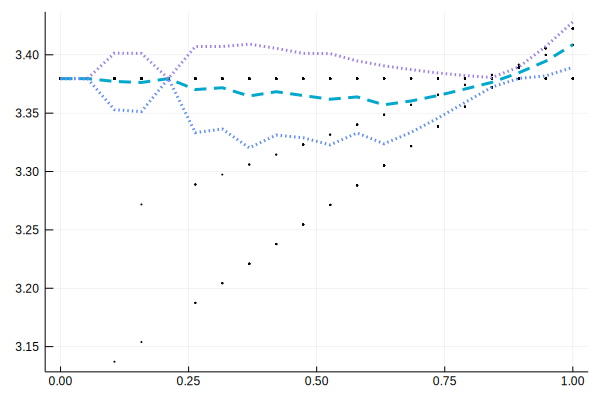

In [76]:
# Al's revenue now
rev2_est_10 = zeros(gran)
rev2_est_100 = zeros(gran)
rev2_est_1000 = zeros(gran)
rstd2_10 = zeros(gran)
rstd2_100 = zeros(gran)
rstd2_1000 = zeros(gran)

for i=1:gran
    rev2_est_10[i] = mean(rev_10[i,:])
    rev2_est_100[i] = mean(rev_100[i,:])
    rev2_est_1000[i] = mean(rev_1000[i,:])
    rstd_10[i] = std(rev_10[i,:])
    rstd_100[i] = std(rev_100[i,:])
    rstd_1000[i] = std(rev_1000[i,:])
end

plot(alphas, rev_10, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, rev2_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev2_est_10 + rstd_10, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev2_est_10 - rstd_10, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
# savefig("type_2_robust_rev10.png")

In [53]:
plot(alphas, rev_10, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, rev2_est_100, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev2_est_100 + rstd_100, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev2_est_100 - rstd_100, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
# savefig("type_2_robust_rev100.png")

In [54]:
plot(alphas, rev_10, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, rev2_est_1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev2_est_1000 + rstd_1000, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev2_est_1000 - rstd_1000, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
# savefig("type_2_robust_rev1000.png")

In [77]:
plot(alphas, rev_opt, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev2_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev2_est_100, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev2_est_1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
savefig("type_2_robust_all.png")

In [44]:
plot(alphas, rev_opt, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev2_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev2_est_100, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev2_est_1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
savefig("type_2_robust_all.png")

In [11]:
using Plots
# Plot of fitted Alpha's
plot(alphas, al10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, al100, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
savefig("type_5_10_100_alphas.png")

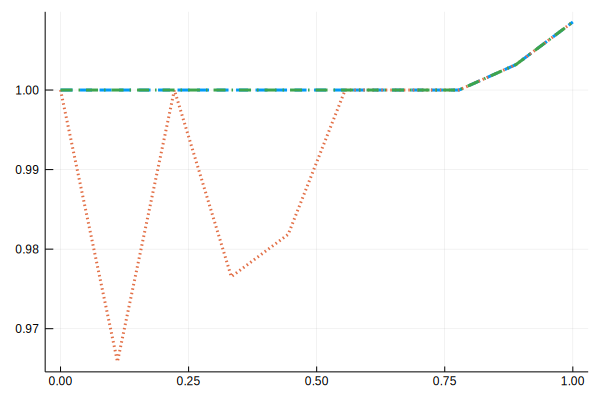

In [45]:
using Plots

# plot(alphas, rev_opq_mix)

# x_vars = ones(gran)
# type5_y_vars = ones(gran, 3)

# for i=1:gran
#      x_vars[i] = alphas[i]
#     type5_y_vars[i,1] = rev_opt[i]/rev_sp[i]
#     type5_y_vars[i,2] = rev_10[i]/rev_sp[i]
#     type5_y_vars[i,3] = rev_100[i]/rev_sp[i]
# end

plot(x_vars, type5_y_vars[:,1], linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type5_y_vars[:,2], linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type5_y_vars[:,3], linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)


# plot(x_vars, type5_y_vars[:,1:3], legend = false)
# savefig("type_5_10_100.png")

In [127]:
# New Experiment 6 - Type 3 Fiting alpha from data

a,b,opq_one, prob_opq_one = makeExp(3, 1, 3)

rev_dp_1, ~ = solvePricing(a, b)
rev_sp_1, ~ = compute_sp(a, b)

rev_opq_one, price_opq_one = solvePricing(opq_one, prob_opq_one)

# Rounds the elements of the price vector.
for i = 1:length(price_opq_one)
    price_opq_one[i] = round(price_opq_one[i], digits = 4)
end
print(price_opq_one)

gran = 50 # just 10

prices_opt = zeros(gran, 3) # necessary for future
rev_opt = zeros(gran)
rev_10 = zeros(gran)
rev_100 = zeros(gran)
al10 = zeros(gran)
al100 = zeros(gran)

# rev_500 = zeros(gran)

rev_dp = ones(gran).*round(rev_dp_1, digits = 4)
rev_sp = ones(gran).*round(rev_sp_1, digits = 4)

alphas = range(0, stop=1, length=gran)

for i=1:gran
    ~, ~, opq_test, prob_opq_test = makeExp(3, alphas[i], 3)
    curr, curr2 = solvePricing(opq_test, prob_opq_test)
    rev_opt[i] = round(curr, digits = 4)
    for j = 1:3
        prices_opt[i,j] = round(curr2[j], digits = 4)
    end
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
[1.0, 7.0, 7.0]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use onl

In [128]:
num_estimates = 50 # one estimation for each of 100 samples
rev_10 = zeros(gran, num_estimates) 
rev_100 = zeros(gran, num_estimates)
rev_1000 = zeros(gran, num_estimates)
al10 = zeros(gran, num_estimates) 
al100 = zeros(gran, num_estimates)
al1000 = zeros(gran, num_estimates)

for i = 1:gran
     a, b, opq_test, prob_opq_test = makeExp(3, alphas[i], 3)
    for j = 1:num_estimates
        
#         for k=1:length(price_opq_one)
#             price_opq_one[k] = 3 + round(3-6*rand(1)[1], digits = 4) # add some randomness to the estimation
#         end
#         price_opq_one = [3.8357, 4.399, 5.6094]
        
        # 10
        samples10 = make_samples(opq_test, prob_opq_test, 10)
        observed10 = compute_purchase_probs(samples10, ones(10)./10, price_opq_one) # price_opq_one
        al10[i,j] = estimate_alpha(a, b, price_opq_one, observed10, 1000)
#         ~,~,opq_10, prob_opq_10 = makeExp(3, al10[i], 3)

        # Find closest alpha on support
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al10[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al10[i,j] - alphas[k])
                curr_ind = k
            end
        end
#         print(curr_ind)
        rev_10[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_test, prob_opq_test), digits = 4)
        
        # 100
        samples100 = make_samples(opq_test, prob_opq_test, 100)
        observed100 = compute_purchase_probs(samples100, ones(100)./100, price_opq_one) # price_opq_one
        al100[i,j] = estimate_alpha(a, b, price_opq_one, observed100, 1000)
#         print(price_opq_one)
#         print(observed100)

        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al100[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al100[i,j] - alphas[k])
                curr_ind = k
            end
        end
        rev_100[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_test, prob_opq_test), digits = 4)
        
        # 1000
        samples1000 = make_samples(opq_test, prob_opq_test, 1000)
        observed1000 = compute_purchase_probs(samples1000, ones(1000)./1000, price_opq_one) # price_opq_one
        al1000[i,j] = estimate_alpha(a, b, price_opq_one, observed1000, 1000)
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al1000[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al1000[i,j] - alphas[k])
                curr_ind = k
            end
        end
        rev_1000[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_test, prob_opq_test), digits = 4)

    end
end

In [129]:
# Compute the percent error's here on revenue and alpha

curr10 = 0
curr100 = 0
curr1000 = 0
revcurr10 = 0
revcurr100 = 0
revcurr1000 = 0

for i = 1:gran
    a, b, opq_test, prob_opq_test = makeExp(3, alphas[i], 3)
    for j=1:num_estimates
        curr10 += abs(alphas[i] - al10[i,j])
        curr100 += abs(alphas[i] - al100[i,j])
        curr1000 += abs(alphas[i] - al1000[i,j])
        curr_opt = round(computeWeightedRevenue(prices_opt[i,:], opq_test, prob_opq_test), digits = 4)
        revcurr10 += abs(curr_opt - rev_10[i,j])/curr_opt
        revcurr100 += abs(curr_opt - rev_100[i,j])/curr_opt
        revcurr1000 += abs(curr_opt - rev_1000[i,j])/curr_opt
    end
end

println(curr10/(gran*num_estimates))
println(curr100/(gran*num_estimates))
println(curr1000/(gran*num_estimates))
println(revcurr10/(gran*num_estimates))
println(revcurr100/(gran*num_estimates))
println(revcurr1000/(gran*num_estimates))

0.2310637249494403
0.08290640027782858
0.027401556658699543
0.03589236546872317
0.0062876983436062055
0.0005191177774525072


In [67]:
mean_est_10 = zeros(gran)
mean_est_100 = zeros(gran)
mean_est_1000 = zeros(gran)
std_10 = zeros(gran)
std_100 = zeros(gran)
std_1000 = zeros(gran)

for i=1:gran
    mean_est_10[i] = mean(al10[i,:])
    mean_est_100[i] = mean(al100[i,:])
    mean_est_1000[i] = mean(al1000[i,:])
    std_10[i] = std(al10[i,:])
    std_100[i] = std(al100[i,:])
    std_1000[i] = std(al1000[i,:])
end

plot(alphas, al10, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, mean_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, mean_est_10 + std_10, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
plot!(alphas, mean_est_10 - std_10, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
savefig("type_3_robust_al10.png")

plot(alphas, al100, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, mean_est_100, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, mean_est_100 + std_100, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
plot!(alphas, mean_est_100 - std_100, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
savefig("type_3_robust_al100.png")

plot(alphas, al1000, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, mean_est_1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, mean_est_1000 + std_1000, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
plot!(alphas, mean_est_1000 - std_1000, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
savefig("type_3_robust_al1000.png")

# Al's revenue now
rev3_est_10 = zeros(gran)
rev3_est_100 = zeros(gran)
rev3_est_1000 = zeros(gran)
rstd_10 = zeros(gran)
rstd_100 = zeros(gran)
rstd_1000 = zeros(gran)

for i=1:gran
    rev3_est_10[i] = mean(rev_10[i,:])
    rev3_est_100[i] = mean(rev_100[i,:])
    rev3_est_1000[i] = mean(rev_1000[i,:])
    rstd_10[i] = std(rev_10[i,:])
    rstd_100[i] = std(rev_100[i,:])
    rstd_1000[i] = std(rev_1000[i,:])
end

plot(alphas, rev_10, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, rev3_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_10 + rstd_10, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_10 - rstd_10, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
savefig("type_3_robust_rev10.png")

plot(alphas, rev_100, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, rev3_est_100, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_100 + rstd_100, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_100 - rstd_100, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
savefig("type_3_robust_rev100.png")

plot(alphas, rev_1000, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, rev3_est_1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_1000 + rstd_1000, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_1000 - rstd_1000, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
savefig("type_3_robust_rev1000.png")

plot(alphas, rev_opt, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_100, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
savefig("type_3_robust_all.png")

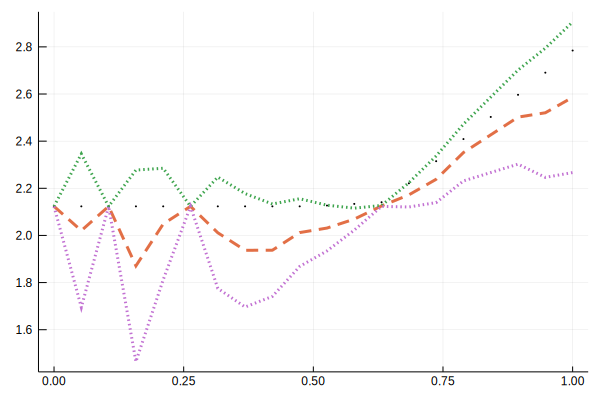

In [62]:
plot(alphas, rev_opt, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, rev3_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_10 + rstd_10, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_10 - rstd_10, linestyle = :dot, linewidth = 3, legend = false, reuse = true)


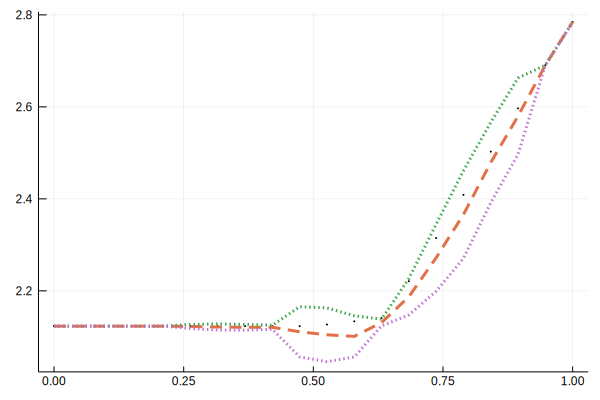

In [68]:
plot(alphas, rev_opt, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, rev3_est_100, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_100 + rstd_100, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_100 - rstd_100, linestyle = :dot, linewidth = 3, legend = false, reuse = true)

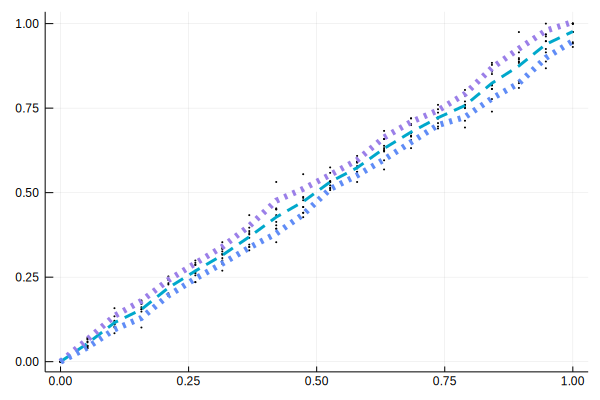

In [56]:
plot(alphas, al1000, seriestype=:scatter, legend = false, markersize = .25, markerstrokestyle = :circle, color = :black)
plot!(alphas, mean_est_1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, mean_est_1000 + std_1000, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
plot!(alphas, mean_est_1000 - std_1000, linestyle = :dot, linewidth = 6, legend = false, reuse = true)
# savefig("type_3_robust_al1000.png")

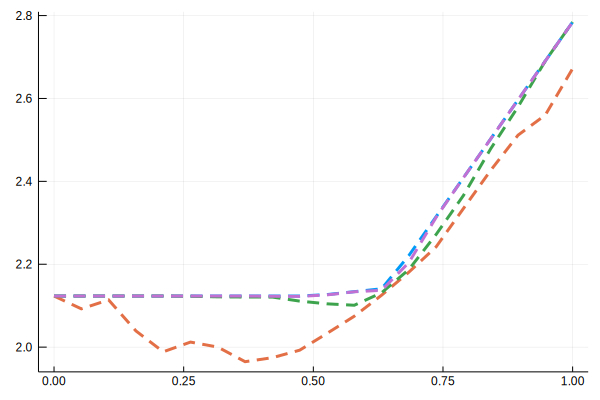

In [69]:
plot(alphas, rev_opt, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_100, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
# savefig("type_3_robust_all.png")

In [71]:
plot(alphas, rev_opt, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_100, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
savefig("type_2_robust_all.png")

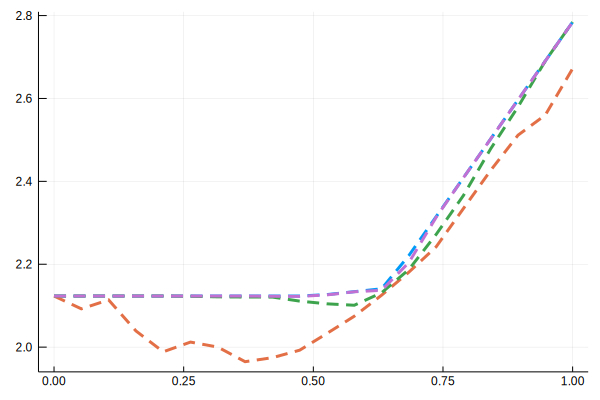

In [73]:
plot(alphas, rev_opt, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_100, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, rev3_est_1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
# savefig("type_3_robust_all.png")

In [13]:
using Plots
# Plot of fitted Alpha's
plot(alphas, al10, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(alphas, al100, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
savefig("type_6_10_100_alphas.png")

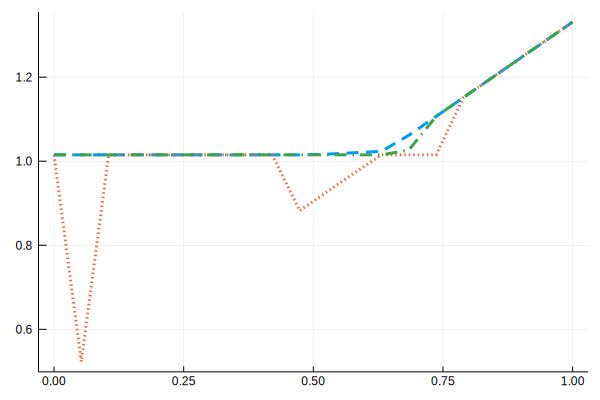

In [54]:
using Plots

# plot(alphas, rev_opq_mix)

# x_vars = ones(gran)
# type6_y_vars = ones(gran, 3)

# for i=1:gran
#      x_vars[i] = alphas[i]
#     type6_y_vars[i,1] = rev_opt[i]/rev_sp[i]
#     type6_y_vars[i,2] = rev_10[i]/rev_sp[i]
#     type6_y_vars[i,3] = rev_100[i]/rev_sp[i]
# end

plot(x_vars, type6_y_vars[:,1], linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type6_y_vars[:,2], linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type6_y_vars[:,3], linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)

# plot(x_vars, type6_y_vars[:,1:3], legend = false)
# savefig("type_6_10_100.png")

In [48]:
# New Experiment 7 - Increasing Variance for type 1 (triangl, std tends from 0 to 2), N=3
# Test with N = 4
gran = 10
rev_opq_half = zeros(gran)
rev_opq_0 = zeros(gran)
rev_opq_1 = zeros(gran)
rev_sp = zeros(gran)
rev_dp = zeros(gran)

std = range(0.1,stop=2,length=gran)
act_std = zeros(gran)

# for i = 1:gran
#     a,b,opq_half, prob_opq_half, act_std[i] = makeExpVar(1, .5, 3, std[i])
#     ~,~,opq_zero, prob_opq_zero, act_std[i] = makeExpVar(1, 0, 3, std[i])
#     ~,~,opq_one, prob_opq_one, act_std[i] = makeExpVar(1, 1, 3, std[i])
#     rev_dp[i], ~ = solvePricing(a, b)
#     rev_opq_half[i], ~ = solvePricing(opq_half, prob_opq_half)
#     rev_opq_0[i], ~ = solvePricing(opq_zero, prob_opq_zero)
#     rev_opq_1[i], ~ = solvePricing(opq_one, prob_opq_one)
#     rev_sp[i], ~ = compute_sp(a, b) 
# end

for i = 1:gran
    a,b,opq_half, prob_opq_half, act_std[i] = makeExpVar(1, .5, 4, std[i])
    ~,~,opq_zero, prob_opq_zero, act_std[i] = makeExpVar(1, 0, 4, std[i])
    ~,~,opq_one, prob_opq_one, act_std[i] = makeExpVar(1, 1, 4, std[i])
    rev_dp[i], ~ = solvePricing(a, b)
    rev_opq_half[i], ~ = solvePricing(opq_half[prob_opq_half .> 0, :], prob_opq_half[prob_opq_half .> 0])
    rev_opq_0[i], ~ = solvePricing(opq_zero[prob_opq_zero .> 0, :], prob_opq_zero[prob_opq_zero .> 0])
    rev_opq_1[i], ~ = solvePricing(opq_one[prob_opq_one .> 0, :], prob_opq_one[prob_opq_one .> 0])
    rev_sp[i], ~ = compute_sp(a, b) 
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

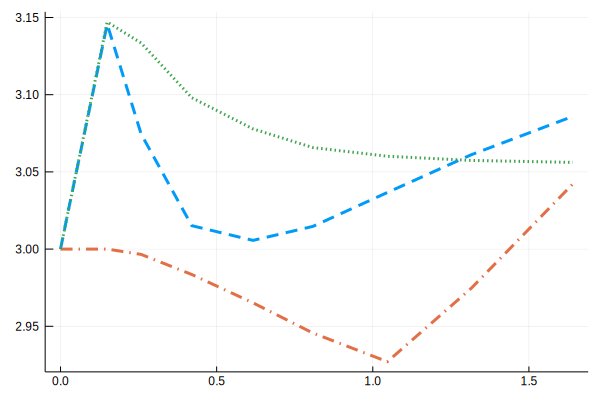

In [15]:
using Plots

plot(act_std, rev_opq_half, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
# plot!(std, rev_opq_0, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(act_std, rev_sp, linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)
plot!(act_std, rev_dp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)

# plot(x_vars, type6_y_vars[:,1:3], legend = false)
# savefig("inc_var_triangle.png")

In [41]:
# New Experiment 8 - Increasing Variance for type 2 (norm, std tends from 0 to 5), N=3

gran = 10
rev_opq_half = zeros(gran)
rev_opq_0 = zeros(gran)
rev_opq_1 = zeros(gran)
rev_sp = zeros(gran)
rev_dp = zeros(gran)

std = range(0,stop=5,length=gran)
act_std = zeros(gran)

for i = 1:gran
    a,b,opq_zero, prob_opq_zero, act_std[i] = makeExpVar(2, 0, 3, std[i])
    ~,~,opq_one, prob_opq_one, act_std[i] = makeExpVar(2, 1, 3, std[i])
    ~,~,opq_half, prob_opq_half, act_std[i] = makeExpVar(2, .5, 3, std[i])
    rev_dp[i], ~ = solvePricing(a, b)
    rev_opq_0[i], ~ = solvePricing(opq_zero, prob_opq_zero)
    rev_opq_1[i], ~ = solvePricing(opq_one, prob_opq_one)
    rev_opq_half[i], ~ = solvePricing(opq_half, prob_opq_half)
    rev_sp[i], ~ = compute_sp(a, b) 
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [42]:
using Plots

plot(act_std, rev_opq_half, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
# plot!(std, rev_opq_1, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(act_std, rev_sp, linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)
plot!(act_std, rev_dp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)

# plot(x_vars, type6_y_vars[:,1:3], legend = false)
savefig("inc_var_normal.png")

In [43]:
# New Experiment 9 - Increasing Variance for type 3 (norm, std tends from 0 to 5), N=3

gran = 10
rev_opq_0 = zeros(gran)
rev_opq_1 = zeros(gran)
rev_sp = zeros(gran)
rev_dp = zeros(gran)

std = range(0,stop=1.3,length=gran)
act_std = zeros(gran)

for i = 1:gran
    a,b,opq_zero, prob_opq_zero, act_std[i] = makeExpVar(3, 0, 3, std[i])
    ~,~,opq_one, prob_opq_one, act_std[i] = makeExpVar(3, 1, 3, std[i])
    ~,~,opq_half, prob_opq_half, act_std[i] = makeExpVar(3, .5, 3, std[i])
    rev_dp[i], ~ = solvePricing(a, b)
    rev_opq_0[i], ~ = solvePricing(opq_zero, prob_opq_zero)
    rev_opq_1[i], ~ = solvePricing(opq_one, prob_opq_one)
    rev_opq_half[i], ~ = solvePricing(opq_half, prob_opq_half)
    rev_sp[i], ~ = compute_sp(a, b) 
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [44]:
using Plots

plot(act_std, rev_opq_half, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
# plot!(act_std, rev_opq_1, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(act_std, rev_sp, linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)
plot!(act_std, rev_dp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)

# plot(x_vars, type6_y_vars[:,1:3], legend = false)
savefig("inc_var_bernoulli.png")

In [18]:
# New Experiment 10 - Mixed Types Pricing
# makeInterestingExp(1, .5, 3, .3, .4, .3)

a,b,~, ~ = makeInterestingExp(1, .5, 3, .4, .3, .3)
rev_dp_1, ~ = solvePricing(a, b)
rev_sp_1, ~ = compute_sp(a, b)

gran = 20

rev_opt = zeros(gran)
rev_dp = ones(gran).*round(rev_dp_1, digits = 4)
rev_sp = ones(gran).*round(rev_sp_1, digits = 4) 

alphas = range(0, stop=1, length=gran)

for i=1:gran
    a,b,opq_mix, prob_opq_mix = makeInterestingExp(1, alphas[i], 3, .4, .3, .3)
    rev_opt[i], ~ = solvePricing(opq_mix, prob_opq_mix)
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [19]:
using Plots

# plot(alphas, rev_opq_mix)

x_vars = ones(gran)
type1_y_vars = ones(gran, 3)

# for i=1:gran
#      x_vars[i] = alphas[i]
#     type1_y_vars[i,1] = rev_opq_mix[i]/rev_sp[i]
#     type1_y_vars[i,2] = rev_opq_zero[i]/rev_sp[i]
#     type1_y_vars[i,3] = rev_opq_one[i]/rev_sp[i]
#     type1_y_vars[i,4] = rev_opt[i]/rev_sp[i]
#     type1_y_vars[i,5] = rev_dp[i]/rev_sp[i]
# #     y_vars[i,6] = rev_sp[i]
# end

for i=1:gran
     x_vars[i] = alphas[i]
    type1_y_vars[i,1] = rev_sp[i]
    type1_y_vars[i,2] = rev_dp[i]
    type1_y_vars[i,3] = rev_opt[i]
end

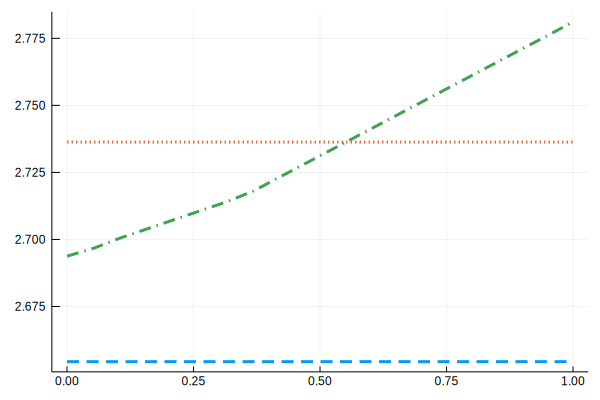

In [20]:
# Symbol[:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
plot(x_vars, type1_y_vars[:,1], linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,2], linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,3], linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)

# savefig("mixed_433_triang.png")

In [21]:
rev_sp[1]

2.6544

In [14]:
# New Experiment 11 - Mixed Types Pricing
# makeInterestingExp(1, .5, 3, .3, .4, .3)

a,b,~, ~ = makeInterestingExp(2, .5, 3, .4, .3, .3)
rev_dp_1, ~ = solvePricing(a, b)
rev_sp_1, ~ = compute_sp(a, b)

gran = 20

rev_opt = zeros(gran)
rev_dp = ones(gran).*round(rev_dp_1, digits = 4)
rev_sp = ones(gran).*round(rev_sp_1, digits = 4) 

alphas = range(0, stop=1, length=gran)

for i=1:gran
    a,b,opq_mix, prob_opq_mix = makeInterestingExp(2, alphas[i], 3, .4, .3, .3)
    rev_opt[i], ~ = solvePricing(opq_mix, prob_opq_mix)
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [15]:
using Plots

# plot(alphas, rev_opq_mix)

x_vars = ones(gran)
type1_y_vars = ones(gran, 3)

# for i=1:gran
#      x_vars[i] = alphas[i]
#     type1_y_vars[i,1] = rev_opq_mix[i]/rev_sp[i]
#     type1_y_vars[i,2] = rev_opq_zero[i]/rev_sp[i]
#     type1_y_vars[i,3] = rev_opq_one[i]/rev_sp[i]
#     type1_y_vars[i,4] = rev_opt[i]/rev_sp[i]
#     type1_y_vars[i,5] = rev_dp[i]/rev_sp[i]
# #     y_vars[i,6] = rev_sp[i]
# end

for i=1:gran
     x_vars[i] = alphas[i]
    type1_y_vars[i,1] = rev_sp[i]
    type1_y_vars[i,2] = rev_dp[i]
    type1_y_vars[i,3] = rev_opt[i]
end

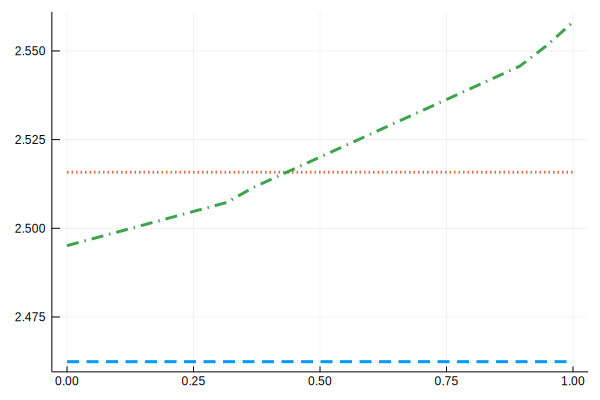

In [16]:
# Symbol[:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
plot(x_vars, type1_y_vars[:,1], linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,2], linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,3], linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)

# savefig("mixed_433_norm.png")

In [17]:
rev_sp[1]

2.4624

In [83]:
# New Experiment 12 - Mixed Types Pricing
# makeInterestingExp(1, .5, 3, .3, .4, .3)

a,b,~, ~ = makeInterestingExp(3, .5, 3, .4, .3, .3)
rev_dp_1, ~ = solvePricing(a, b)
rev_sp_1, ~ = compute_sp(a, b)

gran = 20

rev_opt = zeros(gran)
rev_dp = ones(gran).*round(rev_dp_1, digits = 4)
rev_sp = ones(gran).*round(rev_sp_1, digits = 4) 

alphas = range(0, stop=1, length=gran)

for i=1:gran
    a, b, opq_mix, prob_opq_mix = makeInterestingExp(3, alphas[i], 3, .4, .3, .3)
    rev_opt[i], ~ = solvePricing(opq_mix, prob_opq_mix)
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [84]:
using Plots

# plot(alphas, rev_opq_mix)

x_vars = ones(gran)
type1_y_vars = ones(gran, 3)

# for i=1:gran
#      x_vars[i] = alphas[i]
#     type1_y_vars[i,1] = rev_opq_mix[i]/rev_sp[i]
#     type1_y_vars[i,2] = rev_opq_zero[i]/rev_sp[i]
#     type1_y_vars[i,3] = rev_opq_one[i]/rev_sp[i]
#     type1_y_vars[i,4] = rev_opt[i]/rev_sp[i]
#     type1_y_vars[i,5] = rev_dp[i]/rev_sp[i]
# #     y_vars[i,6] = rev_sp[i]
# end

for i=1:gran
     x_vars[i] = alphas[i]
    type1_y_vars[i,1] = rev_sp[i]
    type1_y_vars[i,2] = rev_dp[i]
    type1_y_vars[i,3] = rev_opt[i]
end

In [88]:
# Symbol[:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
plot(x_vars, type1_y_vars[:,1], linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,2], linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,3], linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)

savefig("mixed_433_bern.png")

In [61]:
# New Experiment 13 - Betas Pricing
# makeRiskNeutralBeta(vals, beta)
# beta is vector of weights, determining how a customer values items. Maybe go back to N=2?

a1,b1,c1,d1 = makeExpBeta(1, [.5, .5], 2)

rev_dp_1, ~ = solvePricing(a1, b1)
rev_sp_1, ~ = compute_sp(a1, b1)

gran = 20
rev_opt = zeros(gran)
rev_dp = ones(gran).*round(rev_dp_1, digits = 4)
rev_sp = ones(gran).*round(rev_sp_1, digits = 4) 

alphas = range(0, stop=1, length=gran)

for i=1:gran
    a, b, opq_mix, prob_opq_mix = makeExpBeta(1, [alphas[i], 1-alphas[i]], 2)
    rev_opt[i], ~ = solvePricing(opq_mix, prob_opq_mix)
end


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [62]:
using Plots

# plot(alphas, rev_opq_mix)

x_vars = ones(gran)
type1_y_vars = ones(gran, 3)

# for i=1:gran
#      x_vars[i] = alphas[i]
#     type1_y_vars[i,1] = rev_opq_mix[i]/rev_sp[i]
#     type1_y_vars[i,2] = rev_opq_zero[i]/rev_sp[i]
#     type1_y_vars[i,3] = rev_opq_one[i]/rev_sp[i]
#     type1_y_vars[i,4] = rev_opt[i]/rev_sp[i]
#     type1_y_vars[i,5] = rev_dp[i]/rev_sp[i]
# #     y_vars[i,6] = rev_sp[i]
# end

for i=1:gran
     x_vars[i] = alphas[i]
    type1_y_vars[i,1] = rev_sp[i]
    type1_y_vars[i,2] = rev_dp[i]
    type1_y_vars[i,3] = rev_opt[i]
end

In [63]:
# Symbol[:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
plot(x_vars, type1_y_vars[:,1], linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,2], linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,3], linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)

savefig("triang_vary_beta.png")

In [64]:
# New Experiment 14 - Betas Pricing
# makeRiskNeutralBeta(vals, beta)
# beta is vector of weights, determining how a customer values items. Maybe go back to N=2?

a1,b1,c1,d1 = makeExpBeta(2, [.5, .5], 2)

rev_dp_1, ~ = solvePricing(a1, b1)
rev_sp_1, ~ = compute_sp(a1, b1)

gran = 20
rev_opt = zeros(gran)
rev_dp = ones(gran).*round(rev_dp_1, digits = 4)
rev_sp = ones(gran).*round(rev_sp_1, digits = 4) 

alphas = range(0, stop=1, length=gran)

for i=1:gran
    a, b, opq_mix, prob_opq_mix = makeExpBeta(2, [alphas[i], 1-alphas[i]], 2)
    rev_opt[i], ~ = solvePricing(opq_mix, prob_opq_mix)
end


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [65]:
using Plots

# plot(alphas, rev_opq_mix)

x_vars = ones(gran)
type1_y_vars = ones(gran, 3)

# for i=1:gran
#      x_vars[i] = alphas[i]
#     type1_y_vars[i,1] = rev_opq_mix[i]/rev_sp[i]
#     type1_y_vars[i,2] = rev_opq_zero[i]/rev_sp[i]
#     type1_y_vars[i,3] = rev_opq_one[i]/rev_sp[i]
#     type1_y_vars[i,4] = rev_opt[i]/rev_sp[i]
#     type1_y_vars[i,5] = rev_dp[i]/rev_sp[i]
# #     y_vars[i,6] = rev_sp[i]
# end

for i=1:gran
     x_vars[i] = alphas[i]
    type1_y_vars[i,1] = round(rev_sp[i], digits = 3)
    type1_y_vars[i,2] = round(rev_dp[i], digits = 3)
    type1_y_vars[i,3] = round(rev_opt[i], digits = 3)
end

In [66]:
# Symbol[:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
plot(x_vars, type1_y_vars[:,1], linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,2], linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,3], linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)

savefig("normal_vary_beta.png")

In [67]:
# New Experiment 15 - Betas Pricing
# makeRiskNeutralBeta(vals, beta)
# beta is vector of weights, determining how a customer values items. Maybe go back to N=2?

a1,b1,c1,d1 = makeExpBeta(3, [.5, .5], 2)

rev_dp_1, ~ = solvePricing(a1, b1)
rev_sp_1, ~ = compute_sp(a1, b1)

gran = 21
rev_opt = zeros(gran)
rev_dp = ones(gran).*round(rev_dp_1, digits = 4)
rev_sp = ones(gran).*round(rev_sp_1, digits = 4) 

alphas = range(0, stop=1, length=gran)

for i=1:gran
    a, b, opq_mix, prob_opq_mix = makeExpBeta(3, [alphas[i], 1-alphas[i]], 2)
    rev_opt[i], ~ = solvePricing(opq_mix, prob_opq_mix)
end


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [68]:
using Plots

# plot(alphas, rev_opq_mix)

x_vars = ones(gran)
type1_y_vars = ones(gran, 3)

# for i=1:gran
#      x_vars[i] = alphas[i]
#     type1_y_vars[i,1] = rev_opq_mix[i]/rev_sp[i]
#     type1_y_vars[i,2] = rev_opq_zero[i]/rev_sp[i]
#     type1_y_vars[i,3] = rev_opq_one[i]/rev_sp[i]
#     type1_y_vars[i,4] = rev_opt[i]/rev_sp[i]
#     type1_y_vars[i,5] = rev_dp[i]/rev_sp[i]
# #     y_vars[i,6] = rev_sp[i]
# end

for i=1:gran
     x_vars[i] = alphas[i]
    type1_y_vars[i,1] = rev_sp[i]
    type1_y_vars[i,2] = rev_dp[i]
    type1_y_vars[i,3] = rev_opt[i]
end

In [69]:
# Symbol[:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
plot(x_vars, type1_y_vars[:,1], linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,2], linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(x_vars, type1_y_vars[:,3], linestyle = :dashdot, linewidth = 3, legend = false, reuse = true)

savefig("bern_vary_beta.png")

In [17]:
a,b,opq_one, prob_opq1 = makeExp(1, 1, 3)
a,b,opq_zero, prob_opq2 = makeExp(1, 0, 3)
solvePricing(a, b)

Academic license - for non-commercial use only


(3.5313116521000176, [4.0, 4.0, 4.0])

In [ ]:
# New Experiment 6 - Type 3 Fiting alpha from data

a,b,opq_one, prob_opq_one = makeExp(3, 1, 3)

rev_dp_1, ~ = solvePricing(a, b)
rev_sp_1, ~ = compute_sp(a, b)

rev_opq_one, price_opq_one = solvePricing(opq_one, prob_opq_one)

# Rounds the elements of the price vector.
for i = 1:length(price_opq_one)
    price_opq_one[i] = round(price_opq_one[i], digits = 4)
end
print(price_opq_one)

gran = 20 # just 10

prices_opt = zeros(gran, 3) # necessary for future
rev_opt = zeros(gran)
rev_10 = zeros(gran)
rev_100 = zeros(gran)
al10 = zeros(gran)
al100 = zeros(gran)

# rev_500 = zeros(gran)

rev_dp = ones(gran).*round(rev_dp_1, digits = 4)
rev_sp = ones(gran).*round(rev_sp_1, digits = 4)

alphas = range(0, stop=1, length=gran)

for i=1:gran
    ~, ~, opq_test, prob_opq_test = makeExp(3, alphas[i], 3)
    curr, curr2 = solvePricing(opq_test, prob_opq_test)
    rev_opt[i] = round(curr, digits = 4)
    for j = 1:3
        prices_opt[i,j] = round(curr2[j], digits = 4)
    end
end

num_estimates = 100 # one estimation for each of 100 samples
rev_10 = zeros(gran, num_estimates) 
rev_100 = zeros(gran, num_estimates)
rev_1000 = zeros(gran, num_estimates)
al10 = zeros(gran, num_estimates) 
al100 = zeros(gran, num_estimates)
al1000 = zeros(gran, num_estimates)

for i = 1:gran
     a, b, opq_test, prob_opq_test = makeExp(3, alphas[i], 3)
    for j = 1:num_estimates
        
#         for k=1:length(price_opq_one)
#             price_opq_one[k] = 3 + round(3-6*rand(1)[1], digits = 4) # add some randomness to the estimation
#         end
#         price_opq_one = [3.8357, 4.399, 5.6094]
        
        # 10
        samples10 = make_samples(opq_test, prob_opq_test, 10)
        observed10 = compute_purchase_probs(samples10, ones(10)./10, price_opq_one) # price_opq_one
        al10[i,j] = estimate_alpha(a, b, price_opq_one, observed10, 1000)
#         ~,~,opq_10, prob_opq_10 = makeExp(3, al10[i], 3)

        # Find closest alpha on support
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al10[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al10[i,j] - alphas[k])
                curr_ind = k
            end
        end
#         print(curr_ind)
        rev_10[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_test, prob_opq_test), digits = 4)
        
        # 100
        samples100 = make_samples(opq_test, prob_opq_test, 100)
        observed100 = compute_purchase_probs(samples100, ones(100)./100, price_opq_one) # price_opq_one
        al100[i,j] = estimate_alpha(a, b, price_opq_one, observed100, 1000)
#         print(price_opq_one)
#         print(observed100)

        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al100[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al100[i,j] - alphas[k])
                curr_ind = k
            end
        end
        rev_100[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_test, prob_opq_test), digits = 4)
        
        # 1000
        samples1000 = make_samples(opq_test, prob_opq_test, 1000)
        observed1000 = compute_purchase_probs(samples1000, ones(1000)./1000, price_opq_one) # price_opq_one
        al1000[i,j] = estimate_alpha(a, b, price_opq_one, observed1000, 1000)
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al1000[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al1000[i,j] - alphas[k])
                curr_ind = k
            end
        end
        rev_1000[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_test, prob_opq_test), digits = 4)

    end
end

In [98]:
# Experiment 16 - Valuations are convex combination of risk-neutral and risk-averse

a,b,opq_zero, prob_opq_zero = makeExp(1, 1, 3)
~,~,opq_one, prob_opq_one = makeExp(1, 0, 3)

rev_dp_1, ~ = solvePricing(a, b)
rev_sp_1, ~ = compute_sp(a, b)

gran = 50
alphas = range(0, stop=1, length=gran)
gammas = range(0, stop=1, length=20) # gammas

num_estimates = 100 # one estimation for each of 100 samples
# rev_10 = zeros(gran, num_estimates) 
# rev_100 = zeros(gran, num_estimates)
# rev_1000 = zeros(gran, num_estimates)
# al10 = zeros(gran, num_estimates) 
# al100 = zeros(gran, num_estimates)
# al1000 = zeros(gran, num_estimates)


# Generate all the optimal prices based on alpha and their revenues
prices_opt = zeros(gran, 3) # necessary for future
rev_opt = zeros(gran) # won't need

for i=1:gran
    ~, ~, opq_test, prob_opq_test = makeExp(1, alphas[i], 3)
    curr, curr2 = solvePricing(opq_test, prob_opq_test)
    rev_opt[i] = round(curr, digits = 4)
    for j = 1:3
        prices_opt[i,j] = round(curr2[j], digits = 4)
    end
end

test_price = [3.8357, 4.399, 5.6094]
al100 = zeros(length(gammas), num_estimates)
al1000 = zeros(length(gammas), num_estimates)
rev_gammas = zeros(length(gammas), num_estimates)
rev_gammas1000 = zeros(length(gammas), num_estimates)

rev_true = zeros(length(gammas))
rev_dp = ones(length(gammas)).*round(rev_dp_1, digits = 4)
rev_sp = ones(length(gammas)).*round(rev_sp_1, digits = 4)

for i=1:length(gammas)
    opq_gammas = gammas[i]*opq_zero + (1-gammas[i])*opq_one
    prob_gammas =  gammas[i]*prob_opq_zero + (1-gammas[i])*prob_opq_one
    rev_true[i],~ = solvePricing(opq_gammas, prob_gammas)
    for j=1:num_estimates
            # Estimate alpha on this market with 100 samples
        samples100 = make_samples(opq_gammas, prob_gammas, 100)
        observed100 = compute_purchase_probs(samples100, ones(100)./100, test_price) # price_opq_one
        al100[i,j] = estimate_alpha(a, b, test_price, observed100, 1000)
        
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al100[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al100[i,j] - alphas[k])
                curr_ind = k
            end
        end
        prices_opt[curr_ind,:] # this is the estimated price!
        rev_gammas[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_gammas, prob_gammas), digits = 4) 
        
        samples1000 = make_samples(opq_gammas, prob_gammas, 1000)
        observed1000 = compute_purchase_probs(samples1000, ones(1000)./1000, test_price) # price_opq_one
        al1000[i,j] = estimate_alpha(a, b, test_price, observed1000, 1000)
        
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al1000[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al1000[i,j] - alphas[k])
                curr_ind = k
            end
        end
        prices_opt[curr_ind,:] # this is the estimated price!
        rev_gammas1000[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_gammas, prob_gammas), digits = 4) 
    end
end

avg_rev_gammas = zeros(length(gammas))
avg_rev_gammas1000 = zeros(length(gammas))

avg_alpha = zeros(length(gammas))
avg_alpha1000 = zeros(length(gammas))

for i=1:length(gammas)
    avg_rev_gammas[i] = mean(rev_gammas[i,:])
    avg_rev_gammas1000[i] = mean(rev_gammas1000[i,:])
    avg_alpha[i] = mean(al100[i,:])
    avg_alpha1000[i] = mean(al1000[i,:])
end

plot(gammas, avg_rev_gammas, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, avg_rev_gammas1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_true, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_dp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_sp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
savefig("type_1_gammas.png")

plot(gammas, avg_alpha,  linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, avg_alpha1000,  linestyle = :dash, linewidth = 3, legend = false, reuse = true)
savefig("type_1_al_gammas.png")

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

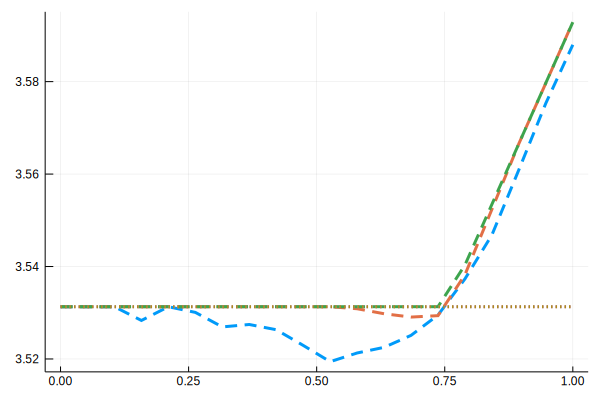

In [99]:
plot(gammas, avg_rev_gammas, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, avg_rev_gammas1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_true, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_dp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_sp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)


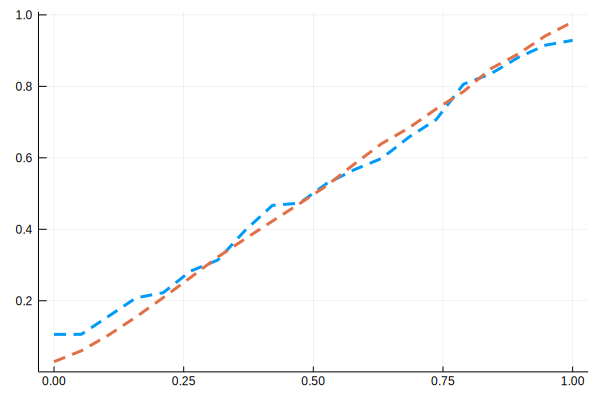

In [100]:
plot(gammas, avg_alpha,  linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, avg_alpha1000,  linestyle = :dash, linewidth = 3, legend = false, reuse = true)

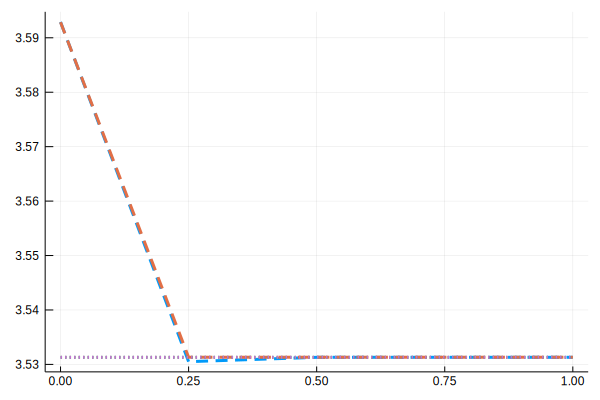

In [20]:
plot(gammas, rev_gammas, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_true, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_dp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_sp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
# savefig("type_1_robust_al10.png")

In [7]:
# Experiment 17 - Valuations are convex combination of risk-neutral and risk-averse

a,b,opq_zero, prob_opq_zero = makeExp(2, 1, 3)
~,~,opq_one, prob_opq_one = makeExp(2, 0, 3)

rev_dp_1, ~ = solvePricing(a, b)
rev_sp_1, ~ = compute_sp(a, b)

gran = 50
alphas = range(0, stop=1, length=gran)
gammas = range(0, stop=1, length=20) # gammas

num_estimates = 100 # one estimation for each of 100 samples
# rev_10 = zeros(gran, num_estimates) 
# rev_100 = zeros(gran, num_estimates)
# rev_1000 = zeros(gran, num_estimates)
# al10 = zeros(gran, num_estimates) 
# al100 = zeros(gran, num_estimates)
# al1000 = zeros(gran, num_estimates)


# Generate all the optimal prices based on alpha and their revenues
prices_opt = zeros(gran, 3) # necessary for future
rev_opt = zeros(gran) # won't need

for i=1:gran
    ~, ~, opq_test, prob_opq_test = makeExp(2, alphas[i], 3)
    curr, curr2 = solvePricing(opq_test, prob_opq_test)
    rev_opt[i] = round(curr, digits = 4)
    for j = 1:3
        prices_opt[i,j] = round(curr2[j], digits = 4)
    end
end

test_price = [2.6008, 3.732, 5.6962]
al100 = zeros(length(gammas), num_estimates)
al1000 = zeros(length(gammas), num_estimates)
rev_gammas = zeros(length(gammas), num_estimates)
rev_gammas1000 = zeros(length(gammas), num_estimates)

rev_true = zeros(length(gammas))
rev_dp = ones(length(gammas)).*round(rev_dp_1, digits = 4)
rev_sp = ones(length(gammas)).*round(rev_sp_1, digits = 4)

for i=1:length(gammas)
    opq_gammas = gammas[i]*opq_zero + (1-gammas[i])*opq_one
    prob_gammas =  gammas[i]*prob_opq_zero + (1-gammas[i])*prob_opq_one
    rev_true[i],~ = solvePricing(opq_gammas, prob_gammas)
    for j=1:num_estimates
            # Estimate alpha on this market with 100 samples
        samples100 = make_samples(opq_gammas, prob_gammas, 100)
        observed100 = compute_purchase_probs(samples100, ones(100)./100, test_price) # price_opq_one
        al100[i,j] = estimate_alpha(a, b, test_price, observed100, 1000)
        
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al100[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al100[i,j] - alphas[k])
                curr_ind = k
            end
        end
        prices_opt[curr_ind,:] # this is the estimated price!
        rev_gammas[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_gammas, prob_gammas), digits = 4) 
        
        samples1000 = make_samples(opq_gammas, prob_gammas, 1000)
        observed1000 = compute_purchase_probs(samples1000, ones(1000)./1000, test_price) # price_opq_one
        al1000[i,j] = estimate_alpha(a, b, test_price, observed1000, 1000)
        
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al1000[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al1000[i,j] - alphas[k])
                curr_ind = k
            end
        end
        prices_opt[curr_ind,:] # this is the estimated price!
        rev_gammas1000[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_gammas, prob_gammas), digits = 4) 
    end
end

avg_rev_gammas = zeros(length(gammas))
avg_rev_gammas1000 = zeros(length(gammas))

avg_alpha = zeros(length(gammas))
avg_alpha1000 = zeros(length(gammas))

for i=1:length(gammas)
    avg_rev_gammas[i] = mean(rev_gammas[i,:])
    avg_rev_gammas1000[i] = mean(rev_gammas1000[i,:])
    avg_alpha[i] = mean(al100[i,:])
    avg_alpha1000[i] = mean(al1000[i,:])
end

plot(gammas, avg_rev_gammas, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, avg_rev_gammas1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_true, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_dp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_sp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
savefig("type_2_gammas.png")

plot(gammas, avg_alpha,  linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, avg_alpha1000,  linestyle = :dash, linewidth = 3, legend = false, reuse = true)
savefig("type_2_al_gammas.png")

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

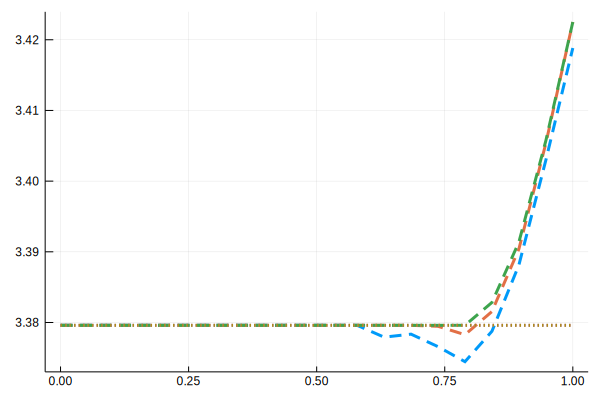

In [8]:
plot(gammas, avg_rev_gammas, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, avg_rev_gammas1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_true, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_dp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_sp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)

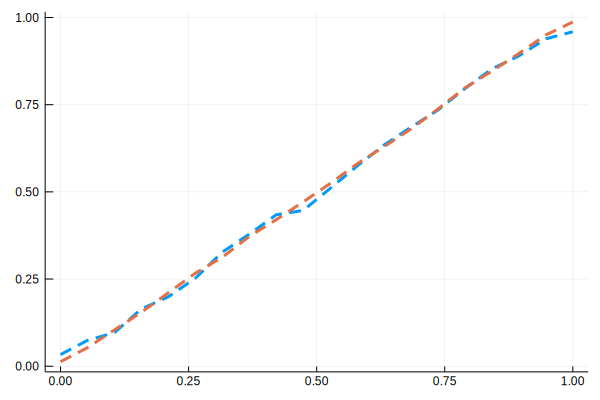

In [103]:
plot(gammas, avg_alpha,  linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, avg_alpha1000,  linestyle = :dash, linewidth = 3, legend = false, reuse = true)

In [104]:
# Experiment 18 - Valuations are convex combination of risk-neutral and risk-averse

a,b,opq_zero, prob_opq_zero = makeExp(3, 1, 3)
~,~,opq_one, prob_opq_one = makeExp(3, 0, 3)

rev_dp_1, ~ = solvePricing(a, b)
rev_sp_1, ~ = compute_sp(a, b)

gran = 50
alphas = range(0, stop=1, length=gran)
gammas = range(0, stop=1, length=20) # gammas

num_estimates = 100 # one estimation for each of 100 samples
# rev_10 = zeros(gran, num_estimates) 
# rev_100 = zeros(gran, num_estimates)
# rev_1000 = zeros(gran, num_estimates)
# al10 = zeros(gran, num_estimates) 
# al100 = zeros(gran, num_estimates)
# al1000 = zeros(gran, num_estimates)


# Generate all the optimal prices based on alpha and their revenues
prices_opt = zeros(gran, 3) # necessary for future
rev_opt = zeros(gran) # won't need

for i=1:gran
    ~, ~, opq_test, prob_opq_test = makeExp(3, alphas[i], 3)
    curr, curr2 = solvePricing(opq_test, prob_opq_test)
    rev_opt[i] = round(curr, digits = 4)
    for j = 1:3
        prices_opt[i,j] = round(curr2[j], digits = 4)
    end
end

test_price = [1, 7, 7]
al100 = zeros(length(gammas), num_estimates)
al1000 = zeros(length(gammas), num_estimates)
rev_gammas = zeros(length(gammas), num_estimates)
rev_gammas1000 = zeros(length(gammas), num_estimates)

rev_true = zeros(length(gammas))
rev_dp = ones(length(gammas)).*round(rev_dp_1, digits = 4)
rev_sp = ones(length(gammas)).*round(rev_sp_1, digits = 4)

for i=1:length(gammas)
    opq_gammas = gammas[i]*opq_zero + (1-gammas[i])*opq_one
    prob_gammas =  gammas[i]*prob_opq_zero + (1-gammas[i])*prob_opq_one
    rev_true[i],~ = solvePricing(opq_gammas, prob_gammas)
    for j=1:num_estimates
            # Estimate alpha on this market with 100 samples
        samples100 = make_samples(opq_gammas, prob_gammas, 100)
        observed100 = compute_purchase_probs(samples100, ones(100)./100, test_price) # price_opq_one
        al100[i,j] = estimate_alpha(a, b, test_price, observed100, 1000)
        
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al100[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al100[i,j] - alphas[k])
                curr_ind = k
            end
        end
        prices_opt[curr_ind,:] # this is the estimated price!
        rev_gammas[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_gammas, prob_gammas), digits = 4) 
        
        samples1000 = make_samples(opq_gammas, prob_gammas, 1000)
        observed1000 = compute_purchase_probs(samples1000, ones(1000)./1000, test_price) # price_opq_one
        al1000[i,j] = estimate_alpha(a, b, test_price, observed1000, 1000)
        
        curr_diff = 1
        curr_ind = 0
        for k=1:gran
            if abs(al1000[i,j] - alphas[k]) < curr_diff
                curr_diff = abs(al1000[i,j] - alphas[k])
                curr_ind = k
            end
        end
        prices_opt[curr_ind,:] # this is the estimated price!
        rev_gammas1000[i,j] = round(computeWeightedRevenue(prices_opt[curr_ind,:], opq_gammas, prob_gammas), digits = 4) 
    end
end

avg_rev_gammas = zeros(length(gammas))
avg_rev_gammas1000 = zeros(length(gammas))

avg_alpha = zeros(length(gammas))
avg_alpha1000 = zeros(length(gammas))

for i=1:length(gammas)
    avg_rev_gammas[i] = mean(rev_gammas[i,:])
    avg_rev_gammas1000[i] = mean(rev_gammas1000[i,:])
    avg_alpha[i] = mean(al100[i,:])
    avg_alpha1000[i] = mean(al1000[i,:])
end

plot(gammas, avg_rev_gammas, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, avg_rev_gammas1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_true, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_dp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_sp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
savefig("type_3_gammas.png")

plot(gammas, avg_alpha,  linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, avg_alpha1000,  linestyle = :dash, linewidth = 3, legend = false, reuse = true)
savefig("type_3_al_gammas.png")

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

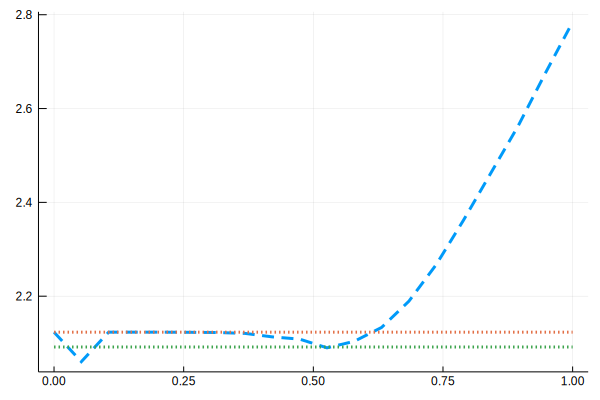

In [113]:
plot(gammas, avg_rev_gammas, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
# plot(gammas, avg_rev_gammas1000, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
# plot!(gammas, rev_true, linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_dp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)
plot!(gammas, rev_sp, linestyle = :dot, linewidth = 3, legend = false, reuse = true)


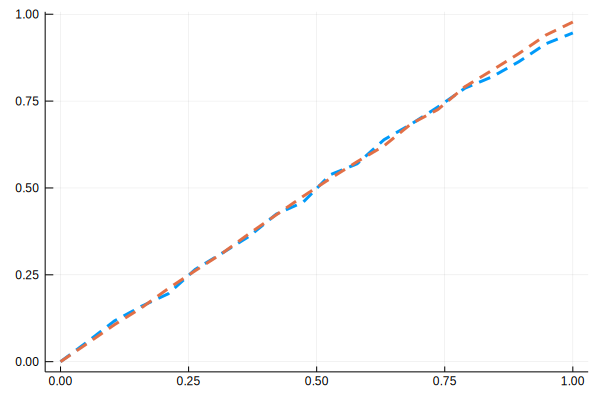

In [106]:
plot(gammas, avg_alpha,  linestyle = :dash, linewidth = 3, legend = false, reuse = true)
plot!(gammas, avg_alpha1000,  linestyle = :dash, linewidth = 3, legend = false, reuse = true)

In [ ]:
########################################################################################################################

In [ ]:
########################################################################################################################

In [95]:
# Make complementaryVals in an interesting way
# Some constant across
# Some pointed
# Some normal

function makeComplementaryVals(para)
    # N = 3
    a,b,~,~ = makeExp(para, 0, 1)
    new_prob = vcat(b,vcat(b,b))
    new_mat = ones(3*length(a), 3)
    
    for i=1:length(a)
        new_mat[i,1] = max(max(maximum(a) - a[i], a[i]), 5)
        new_mat[i,2] = min(min(maximum(a) - a[i], a[i]), 3)
        new_mat[i,3] = min(min(maximum(a) - a[i], a[i]), 3)
        new_mat[i+length(a),1] = min(min(maximum(a) - a[i], a[i]), 3)
        new_mat[i+length(a),2] = max(max(maximum(a) - a[i], a[i]), 5)
        new_mat[i+length(a),3] = min(min(maximum(a) - a[i], a[i]), 3)
        new_mat[i+2*length(a),1] = min(min(maximum(a) - a[i], a[i]), 3)
        new_mat[i+2*length(a),2] = min(min(maximum(a) - a[i], a[i]), 3)
        new_mat[i+2*length(a),3] = max(max(maximum(a) - a[i], a[i]), 5)
    end

    return new_mat, new_prob  
end


makeComplementaryVals (generic function with 2 methods)

In [104]:
a1,b1 = makeComplementaryVals(1)
a2,b2 = makeComplementaryVals(2)
a3,b3 = makeComplementaryVals(3)
# solvePricing(a1, b1)

opq_types_mat_RA = makeRiskAverse(a1)
opq_types_mat_RN = makeRiskNeutral(a1)
opq_1 = vcat(opq_types_mat_RA, opq_types_mat_RN)
opq_prob_1 = vcat(b1.*.5, b1.*(1-.5))

solvePricing(makeRiskAverse(a3), b3), solvePricing(a3, b3)


Academic license - for non-commercial use only
Academic license - for non-commercial use only


((18.0, [3.0, 3.0, 6.0]), (18.0, [6.0, 6.0, 6.0]))

In [ ]:
# plotting code - straight forward and fun
using PyPlot

gran = 21
# supp = linspace(0, 1, gran) # These are the values of B we check
sol_sp = ones(1,gran).*rev_sp
sol_dp = ones(1,gran).*rev_dp
sol_opq = result

plot(al[:,1], sol_sp[1,:], color="black", linewidth=3.0, linestyle="--", marker = "x", markersize=5.0)
plot(al[:,1], sol_dp[1,:], color="black", linewidth=3.0, linestyle=":", marker = "x", markersize=5.0)
plot(al[:,1], sol_opq[:,1], color="black", linewidth=3.0, marker = "x", markersize=5.0)
margins(.025)

In [10]:
# Experiment, N=2 and complementary valuations
a = ones(4)
length(a)

4

In [57]:
data = makeComplementaryVals(1000, 1, 1, 1, 1)
data_ra = makeRiskAverse(data)
data_rn = makeRiskAverse(data)
data_rn_beta = makeRiskNeutralBeta(data, [.75, .25])

types_prob = ones(length(data[:,1]))./length(data[:,1])
a1,b1 = solvePricing(data, types_prob)
a2,b2 = solvePricing(data_ra, types_prob)
a3,b3 = solvePricing(data_rn, types_prob)
a4,b4 = solvePricing(data_rn_beta, types_prob)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(0.6762335317134479, [0.951368, 0.703757])

In [56]:
b1

2-element Array{Float64,1}:
 0.952878321689353
 0.952878321689351

In [58]:
# test fidelity
data = makeComplementaryVals(10000, 1, 1, 1, 1)
data_ra = makeRiskAverse(data)
data_rn = makeRiskAverse(data)
data_rn_beta = makeRiskNeutralBeta(data, [.75, .25])

N = length(data[:,1])

println(compute_sp(data, ones(N)./N)) 
println([a1, computeRevenue(b1, data)/N])
println([a2, computeRevenue(b2, data)/N])
println([a3, computeRevenue(b3, data)/N])
println([a4, computeRevenue(b4, data)/N])

(0.6558852527831684, 0.9943681819029002)
[0.673777, 0.653126]
[0.720966, 0.482968]
[0.720966, 0.482968]
[0.676234, 0.6297]


In [5]:
supp = [.9, .1, 0]
supp_probs = [1/27, 2/3, 8/27]
types_mat,types_prob = makeiid3(supp,supp_probs)

([0.9 0.9 0.9; 0.9 0.1 0.9; … ; 0.0 0.1 0.0; 0.0 0.0 0.0], [5.08053e-5, 0.000914495, 0.000406442, 0.000914495, 0.0164609, 0.00731596, 0.000406442, 0.00731596, 0.00325154, 0.000914495  …  0.0585277, 0.000406442, 0.00731596, 0.00325154, 0.00731596, 0.131687, 0.0585277, 0.00325154, 0.0585277, 0.0260123])

In [6]:
solvePricing(types_mat, types_prob)

Academic license - for non-commercial use only


(0.12853223593964336, [0.9, 0.9, 0.1])

In [ ]:
norm_ds = makeVals(1000, 3, 1, 1, 1)
gumbel_ds = makeVals(1000, 3, 1, 1, 1)
uni_ds = makeVals(1000, 3, 1, 1, 1)
types_prob = ones(1000)./1000;

In [33]:
# Exp 1 - Normal
N = 1000
norm_ds = makeVals(N, 3, 1, 1.5, 2)
ra_norm_ds = makeRiskAverse(norm_ds)
rn_norm_ds = makeRiskNeutral(norm_ds)
types_prob = ones(N)./N ;

1000×3 Array{Float64,2}:
 2.6  2.3  0.0
 4.3  0.0  4.5
 2.1  0.8  2.0
 1.1  0.7  0.2
 0.8  2.2  0.4
 2.0  1.4  0.8
 1.7  0.0  0.0
 0.0  2.9  0.3
 0.7  1.1  2.1
 0.1  1.3  0.0
 0.3  0.0  3.1
 1.3  1.5  1.3
 3.3  4.7  3.1
 ⋮            
 1.0  2.9  0.7
 1.8  2.9  2.0
 0.9  3.6  2.6
 2.2  0.0  2.0
 0.0  1.8  3.2
 1.0  1.3  1.9
 0.8  1.8  1.7
 4.1  2.0  1.1
 1.1  0.8  0.1
 1.6  1.1  4.4
 1.8  6.2  1.1
 0.6  1.8  1.6

In [49]:
start = time()
norm_1, norm_2 = solvePricing(norm_ds, types_prob)
print(time() - start)
start = time()
ra_norm_1, ra_norm_2 = solvePricing(ra_norm_ds, types_prob)
print(time() - start)
start = time()
rn_norm_1, rn_norm_2 = solvePricing(rn_norm_ds, types_prob)
print(time() - start)
norm_1, ra_norm_1, rn_norm_1

Academic license - for non-commercial use only
1416.5960001945496Academic license - for non-commercial use only
725.6340000629425Academic license - for non-commercial use only
2293.496999979019

(1.4768000000000006, 1.4855000000000014, 1.47925)

In [ ]:
# Evaluation code
N = 100000
norm_test = makeVals(N, 3, 1, 1.5, 2)
ra_norm_test = makeRiskAverse(norm_test)
rn_norm_test = makeRiskNeutral(norm_test);
compute_sp(norm_test, ones(N)./N), computeRevenue(norm_2, rn_norm_test)/N, computeRevenue(ra_norm_2, ra_norm_test)/N, computeRevenue(rn_norm_2, rn_norm_test)/N

In [16]:
# Exp 3 - Uni
N = 1000
norm_ds = makeVals(N, 3, 3, 3, 3)
ra_norm_ds = makeRiskAverse(norm_ds)
rn_norm_ds = makeRiskNeutral(norm_ds)
types_prob = ones(N)./N ;

start = time()
norm_1, norm_2 = solvePricing(norm_ds, types_prob)
print(time() - start)
start = time()
ra_norm_1, ra_norm_2 = solvePricing(ra_norm_ds, types_prob)
print(time() - start)
start = time()
rn_norm_1, rn_norm_2 = solvePricing(rn_norm_ds, types_prob)
print(time() - start)
norm_1, ra_norm_1, rn_norm_1

Academic license - for non-commercial use only
139.15899991989136Academic license - for non-commercial use only
88.42600011825562Academic license - for non-commercial use only
48434.576999902725

(3.3711000000000055, 3.365100000000008, 3.36610005866963)